In [110]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier, Pool

import xgboost as xgb

from scipy.stats import pearsonr

from confusion_matrix import plot_confusion_matrix

In [2]:
# Plots stuff
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8
%matplotlib inline
sns.set()
plt.rcParams['figure.dpi'] = 100

# Data import

In [3]:
ade_raw_df = pd.read_spss('antipsychotics_safety.sav')

In [4]:

import pyreadstat
ade_raw_df, meta = pyreadstat.read_sav('antipsychotics_safety.sav')
ade_raw_df.head(5)

ID  Отделение  Пол  Возраст  Срок_госп  Диагноз_1  Диагноз_2  Др_диагнозы  \
0  1.0        3.0  2.0     17.0       65.0        1.0        1.0          0.0   
1  2.0        4.0  1.0     15.0      202.0        1.0        4.0          0.0   
2  3.0        3.0  2.0     14.0       89.0        1.0        1.0          0.0   
3  4.0        5.0  2.0     14.0       60.0       10.0        1.0          0.0   
4  5.0        6.0  1.0      8.0       24.0        1.0        7.0          0.0   

   Все_госп  Длит_заболев  ...  НПР_всего  АП_1_Тип  АП_2_Тип  АП_3_Тип  \
0       2.0          36.0  ...        1.0       1.0       0.0       0.0   
1       1.0           0.0  ...        0.0       1.0       2.0       0.0   
2       1.0           1.0  ...        2.0       1.0       0.0       0.0   
3       1.0           2.0  ...        0.0       1.0       1.0       0.0   
4       2.0          15.0  ...        0.0       1.0       0.0       0.0   

   AP_1_Off  AP_2_Off  AP_3_Off  NT_Off  AD_Off  Off_Rate  
0       0.0       0.0       0.0     0.0     1.0       1.0  
1       0.0       1.0       0.0     0.0     0.0       1.0  
2       0.0       0.0       0.0     0.0     0.0       0.0  
3       0.0       0.0       0.0     0.0     0.0       0.0  
4       1.0       0.0       0.0     0.0     0.0       1.0  

[5 rows x 156 columns]

In [5]:
list(zip(ade_raw_df.columns, meta.column_labels))

[('ID', None),
 ('Отделение', None),
 ('Пол', None),
 ('Возраст', None),
 ('Срок_госп', 'Срок госпитализации (дни)'),
 ('Диагноз_1', 'Диагноз при поступлении'),
 ('Диагноз_2', 'Диагноз при выписке'),
 ('Др_диагнозы', 'Сопутствующие диагнозы'),
 ('Все_госп', 'Общее число госпитализаций (включая настоящую)'),
 ('Длит_заболев', 'Длительность заболевания (мес)'),
 ('Вед_синдром', 'Ведущий синдром'),
 ('АП_1', 'Первый применяемый антипсихотик'),
 ('АП_1_старт', 'Стартовая доза первого антипсихотика (мг/сут)'),
 ('АП_1_Макс', 'Максимальная доза первого антипсихотика (мг/сут)'),
 ('АП_1_Подд', 'Поддерживающая доза первого антипсихотика (мг/сут)'),
 ('АП_1_старт_экв',
  'Первый антипсихотик, стартовая доза (аминазиновый эквивалент, мг/сут)'),
 ('АП_1_макс_экв',
  'Первый антипсихотик, максимальная доза (аминазиновый эквивалент, мг/сут)'),
 ('АП_1_подд_экв',
  'Первый антипсихотик, поддерживающая доза (аминазиновый эквивалент, мг/сут)'),
 ('АП_1_Отм', 'Факт отмены первого антипсихотика'),
 ('АП

In [6]:
TARGET_COLS = [col for col in ade_raw_df.columns if col.startswith('НПР')]
TARGET_COLS

['НПР_Антигист',
 'НПР_рвота',
 'НПР_лейк',
 'НПР_седация',
 'НПР_сыпь',
 'НПР_отмена',
 'НПР_доза',
 'НПР_запор',
 'НПР_Рацио',
 'НПР_госпит',
 'НПР_ЭПС',
 'НПР_факт',
 'НПР_всего']

In [7]:
ade_raw_df[TARGET_COLS].describe()

НПР_Антигист   НПР_рвота  НПР_лейк  НПР_седация    НПР_сыпь  \
count    450.000000  450.000000     450.0   450.000000  450.000000   
mean       0.008889    0.002222       0.0     0.013333    0.006667   
std        0.093965    0.047140       0.0     0.114825    0.081468   
min        0.000000    0.000000       0.0     0.000000    0.000000   
25%        0.000000    0.000000       0.0     0.000000    0.000000   
50%        0.000000    0.000000       0.0     0.000000    0.000000   
75%        0.000000    0.000000       0.0     0.000000    0.000000   
max        1.000000    1.000000       0.0     1.000000    1.000000   

       НПР_отмена    НПР_доза   НПР_запор   НПР_Рацио  НПР_госпит     НПР_ЭПС  \
count  450.000000  450.000000  450.000000  450.000000  450.000000  450.000000   
mean     0.055556    0.013333    0.002222    0.002222    0.015556    0.200000   
std      0.229316    0.114825    0.047140    0.047140    0.123886    0.400445   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

         НПР_факт   НПР_всего  
count  450.000000  450.000000  
mean     0.280000    0.320000  
std      0.449499    0.546134  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      1.000000    1.000000  
max      1.000000    2.000000

In [8]:
ade_raw_df[TARGET_COLS].sum(axis=0)

НПР_Антигист      4.0
НПР_рвота         1.0
НПР_лейк          0.0
НПР_седация       6.0
НПР_сыпь          3.0
НПР_отмена       25.0
НПР_доза          6.0
НПР_запор         1.0
НПР_Рацио         1.0
НПР_госпит        7.0
НПР_ЭПС          90.0
НПР_факт        126.0
НПР_всего       144.0
dtype: float64

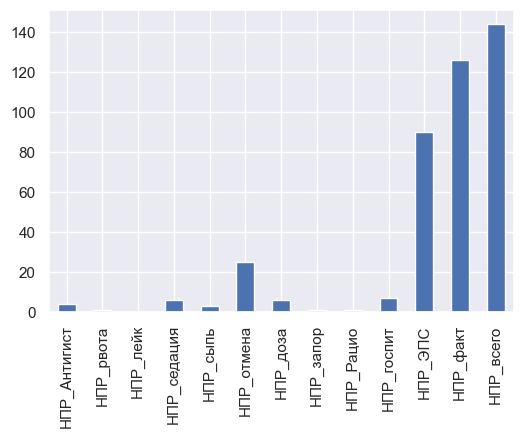

In [9]:
ade_raw_df[TARGET_COLS].sum(axis=0).plot(kind='bar')

In [10]:
ade_raw_df['T18_НПР'].describe()

count    450.000000
mean       0.202222
std        1.032434
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       10.000000
Name: T18_НПР, dtype: float64

In [11]:
ade_raw_df['T18_НПР'].unique()

array([ 0.,  1.,  5.,  2.,  3.,  6.,  4.,  7.,  8.,  9., 10.])

In [12]:
v_c = ade_raw_df['АП_1_Отм_пр'].value_counts()
v_c.index = v_c.index.map(meta.variable_value_labels['АП_1_Отм_пр'])
v_c

Не отменялся         248
Неэффективность      119
Без обоснования       43
Наличие НПР           39
Нет необходимости      1
Name: АП_1_Отм_пр, dtype: int64

In [13]:
v_c = ade_raw_df['АП_2_Отм_пр'].value_counts()
v_c.index = v_c.index.map(meta.variable_value_labels['АП_2_Отм_пр'])
v_c

Не отменялся         376
Без обоснования       34
Неэффективность       22
Наличие НПР           12
Нет необходимости      6
Name: АП_2_Отм_пр, dtype: int64

In [14]:
v_c = ade_raw_df['АП_3_отм_пр'].value_counts()
v_c.index = v_c.index.map(meta.variable_value_labels['АП_3_отм_пр'])
v_c

Не отменялся       438
Без обоснования      7
Неэффективность      3
Наличие НПР          2
Name: АП_3_отм_пр, dtype: int64

In [15]:
ade_raw_df.dropna(axis=1).columns

Index(['ID', 'Отделение', 'Пол', 'Возраст', 'Срок_госп', 'Диагноз_1',
       'Диагноз_2', 'Др_диагнозы', 'Все_госп', 'Вед_синдром',
       ...
       'НПР_всего', 'АП_1_Тип', 'АП_2_Тип', 'АП_3_Тип', 'AP_1_Off', 'AP_2_Off',
       'AP_3_Off', 'NT_Off', 'AD_Off', 'Off_Rate'],
      dtype='object', length=149)

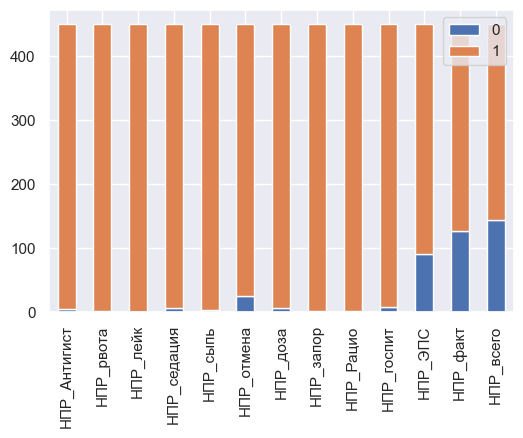

In [16]:
pd.DataFrame(
    [ade_raw_df[TARGET_COLS].sum(axis=0), ade_raw_df.shape[0] -
     ade_raw_df[TARGET_COLS].sum(axis=0)]
).T.plot(kind='bar', stacked=True)

# X & Y generation

In [17]:
Y = ade_raw_df['НПР_факт']
Y.describe()

count    450.000000
mean       0.280000
std        0.449499
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: НПР_факт, dtype: float64

In [18]:
NON_PREDICTOR_COLS = np.array([
    'ID',
    'Отделение',
    'T18',
    'T18_НПР',
    'T18_причина',
    'T19',
    'T19_НПР',
    'T19_причина',
    'T22',
    'T25',
    'Т25_причина',
    'T30',
    'Т16_вредНПР',
    'Т16_предотврНПР',
    'Т16_типНПР',
    'Т16_Наранжо',
    'Т17_Причина',
    'T17_вредНПР',
    'T17_предотврНПР',
    'T17_типНПР',
    'T17_Наранжо',
    'Т18_вредНПР',
    'Т18_предотврНПР',
    'Т18_типНПР',
    'Т18_Наранжо',
    'T19_вредНПР',
    'Т19_предотврНПР',
    'Т19_типНПР',
    'Т19_Наранжо',
    'Т25_вредНПР',
    'Т25_предовтрНПР',
    'Т25_типНПР',
    'Т25_Наранжо',
    'Т1_1_вредНПР',
    'Т1_1_предотврНПР',
    'Т1_1_типНПР',
    'Т1_1_Наранжо',
    'Т4_вредНПР',
    'Т4_предотврНПР',
    'Т4_типНПР',
    'Т4_Наранжо',
    'T1_Причина',
    'T1_вредНПР',
    'T1_предотврНПР',
    'T1_типНПР',
    'T1_Наранжо',
    'T30_Описание',
    'T30_вредНПР',
    'T30_предотврНПР',
    'T30_типНПР',
    'T30_Наранжо',
    'НПР_Антигист',
    'НПР_рвота',
    'НПР_лейк',
    'НПР_седация',
    'НПР_сыпь',
    'НПР_отмена',
    'НПР_доза',
    'НПР_запор',
    'НПР_Рацио',
    'НПР_госпит',
    'НПР_ЭПС',
    'НПР_факт',
    'НПР_всего',
])

CATEGORICAL_COLS = np.array([
    'Диагноз_1',
    'Диагноз_2',
    'Др_диагнозы',
    'Вед_синдром',
    'АП_1',
    'АП_1_Отм',
    'АП_1_Отм_пр',
    'АП_2',
    'АП_2_Отм',
    'АП_2_Отм_пр',
    'АП_3',
    'АП_3_отм',
    'АП_3_отм_пр',
    'АП_сед',
    'АП_сед_отм',
    'АП_сед_отм_пр',
    'АД',
    'АД_отм',
    'АД_отм_пр',
    'НТ',
    'НТ_отм',
    'НТ_отм_пр',
    'Транк',
    'Корректор',
    'Отмена_корр',
    'T1',
    'Т4',
    'ЭПС',
#     'ЭПС_причина',
#     'ЭПС_Вред_НПР',
#     'ЭПС_Предотвр_НПР',
#     'ЭПС_Тип_НПР',
#     'ЭПС_Шкала_Наранжо',
])

In [19]:
X = ade_raw_df.drop(columns=NON_PREDICTOR_COLS)
X[CATEGORICAL_COLS] = X[CATEGORICAL_COLS].astype(int)
# Synthetic cols
X['Psych_drugs_count'] = (
    X['АП_1'].astype(bool).astype(int) + X['АП_2'].astype(bool).astype(int) + X['АП_3'].astype(bool).astype(int) +
    X['АП_сед'].astype(bool).astype(int) + X['АД'].astype(bool).astype(int) + X['НТ'].astype(bool).astype(int) + X['ЭПС'].astype(bool).astype(int)
)

X['Extra_AP_drugs'] = X['АП_2'].astype(bool) | X['АП_3']


X.describe()

Пол     Возраст   Срок_госп   Диагноз_1   Диагноз_2  \
count  450.000000  450.000000  450.000000  450.000000  450.000000   
mean     1.504444   14.515556   59.364444    7.666667   10.448889   
std      0.500537    2.208705   31.088502    9.677886    9.732654   
min      1.000000    7.000000    3.000000    0.000000    0.000000   
25%      1.000000   13.000000   39.000000    1.000000    3.000000   
50%      2.000000   15.000000   53.000000    2.000000    8.000000   
75%      2.000000   16.000000   72.750000   11.000000   16.750000   
max      2.000000   17.000000  212.000000   41.000000   38.000000   

       Др_диагнозы    Все_госп  Длит_заболев  Вед_синдром        АП_1  ...  \
count   450.000000  450.000000    276.000000   450.000000  450.000000  ...   
mean      0.255556    1.591111      9.668478     3.680000    4.104444  ...   
std       1.235708    1.060282     11.107641     1.536432    8.730319  ...   
min       0.000000    1.000000      0.000000     1.000000    1.000000  ...   
25%       0.000000    1.000000      2.000000     3.000000    1.000000  ...   
50%       0.000000    1.000000      6.000000     3.000000    2.000000  ...   
75%       0.000000    2.000000     12.250000     4.000000    5.000000  ...   
max       9.000000    9.000000     72.000000     9.000000  102.000000  ...   

         АП_1_Тип    АП_2_Тип    АП_3_Тип    AP_1_Off    AP_2_Off    AP_3_Off  \
count  450.000000  450.000000  450.000000  450.000000  450.000000  450.000000   
mean     1.231111    0.484444    0.600000    0.084444    0.068889    0.093333   
std      0.422012    0.728655    0.814676    0.278363    0.253547    0.291223   
min      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    0.000000    0.000000    0.000000   
max      2.000000    2.000000    2.000000    1.000000    1.000000    1.000000   

           NT_Off      AD_Off    Off_Rate  Psych_drugs_count  
count  450.000000  450.000000  450.000000         450.000000  
mean     0.264444    0.008889    0.520000           3.997778  
std      0.441528    0.093965    0.694105           1.337316  
min      0.000000    0.000000    0.000000           1.000000  
25%      0.000000    0.000000    0.000000           3.000000  
50%      0.000000    0.000000    0.000000           4.000000  
75%      1.000000    0.000000    1.000000           5.000000  
max      1.000000    1.000000    3.000000           7.000000  

[8 rows x 93 columns]

In [20]:
# ade_raw_df['T1'].describe()
meta.variable_value_labels['ЭПС_причина']

{0.0: 'Нет НПР',
 1.0: 'Назначено несколько антипсихотиков',
 2.0: 'Галоперидол',
 3.0: 'Трифлуоперазин',
 4.0: 'Зуклопентиксол',
 5.0: 'Рисперидон',
 6.0: 'Хлорпротиксен',
 7.0: 'Флупентиксол',
 8.0: 'Хлорпромазин',
 9.0: 'Перфеназин'}

# Important features plot logic

In [21]:
def plot_important_features(X, coefficients, name, normalize=True):
    ##### TOP MOST IMPORTANT FEATURES PLOT

    N_to_print = min(20, X.shape[1]) # Plot up to 20 most important features
    y_pos = range(N_to_print)
    fig, ax = plt.subplots()
    plt.figure(figsize=(10,7))

    feature_importance = coefficients.round(4)
    feature_importance = zip(X.keys(), feature_importance)
    feature_importance = np.array(sorted(
        map(
            lambda pair: pair[1] != abs(pair[1]) and ('[negative]' + pair[0], abs(pair[1])) or (pair[0], pair[1]),
            feature_importance
        ),
        key=lambda x:x[1], reverse=True))
    ax.barh(y_pos, feature_importance[:N_to_print, 1].astype('float'), align='center', color='green')
    ax.set_yticks(np.arange(N_to_print))
    ax.set_yticklabels(feature_importance[:N_to_print, 0])
    ax.invert_yaxis()
    ax.set_xlabel(f'Importance/coefficients for {name}')

    plt.show()

# ROC AUC Curve plot logic

In [129]:
def plot_roc_auc_curve(classifier, cv, X, y, name='model'):
    tprs = []
    aucs = []
    
    train_tprs = []
    train_aucs = []
    
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"Receiver operating characteristic for {name}")
    ax.legend(loc="lower right")
    plt.show()
    # Plot train ROC AUC
    for i, (train, test) in enumerate(cv.split(X, y)):
        # Train ROC AUC
        viz = plot_roc_curve(classifier, X[train], y[train],
                             name='TRAIN ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        train_tprs.append(interp_tpr)
        train_aucs.append(viz.roc_auc)
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(train_tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(train_aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean TRAIN ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(train_tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"TRAIN Receiver operating characteristic for {name}")
    ax.legend(loc="lower right")
    plt.show()


# Binary classification using CatBoost model

0:	learn: 0.2758691	total: 59.7ms	remaining: 59.7ms
1:	learn: 0.2431984	total: 63ms	remaining: 0us
0:	learn: 0.2434757	total: 3.68ms	remaining: 3.68ms
1:	learn: 0.1744673	total: 6.02ms	remaining: 0us
0:	learn: 0.2632643	total: 2.61ms	remaining: 2.61ms
1:	learn: 0.2318444	total: 4.59ms	remaining: 0us
0:	learn: 0.2820509	total: 4.78ms	remaining: 4.78ms
1:	learn: 0.2396311	total: 7.75ms	remaining: 0us
0:	learn: 0.2360402	total: 3.17ms	remaining: 3.17ms
1:	learn: 0.2102173	total: 6.16ms	remaining: 0us


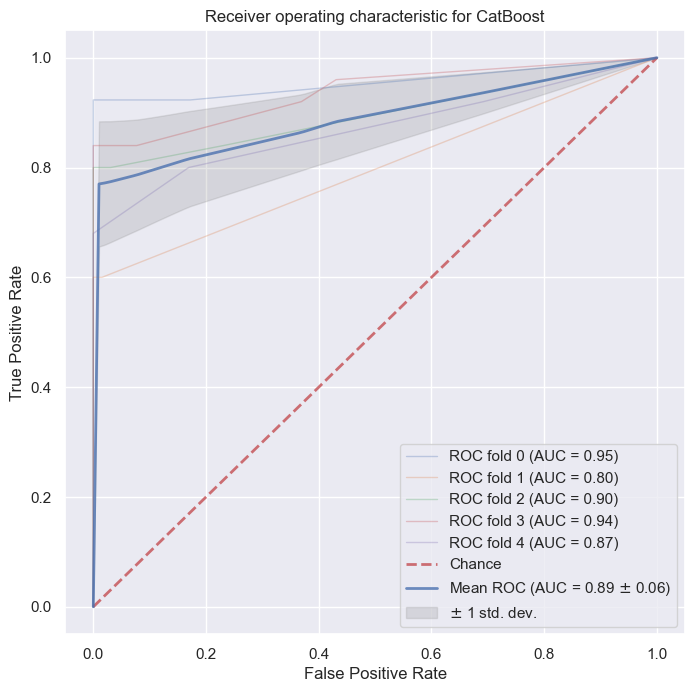

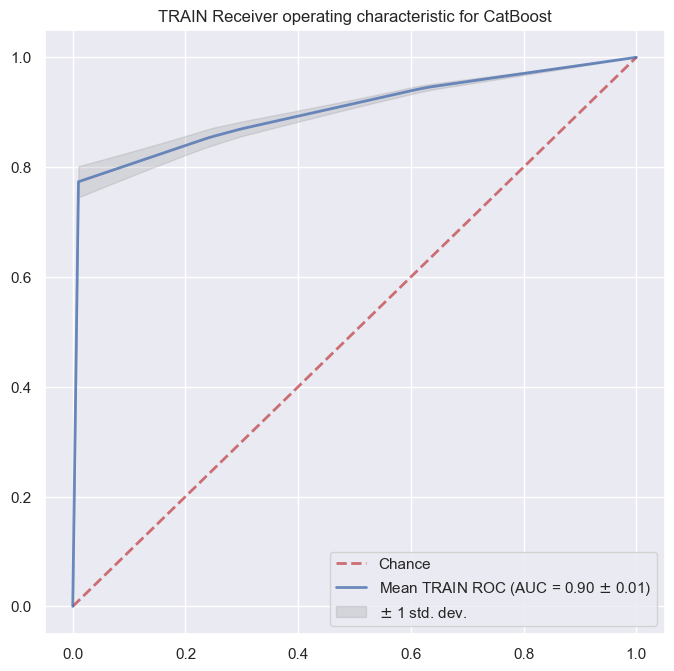

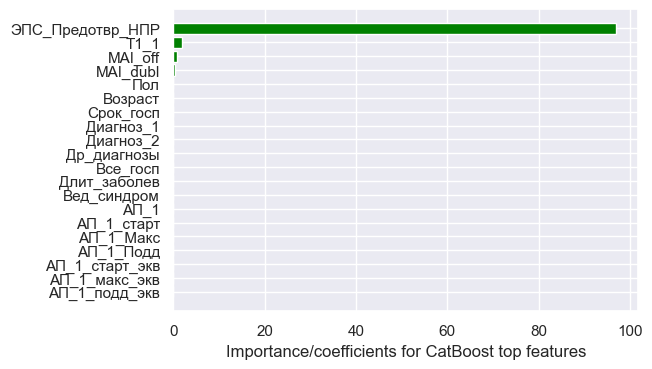

<Figure size 1000x700 with 0 Axes>

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


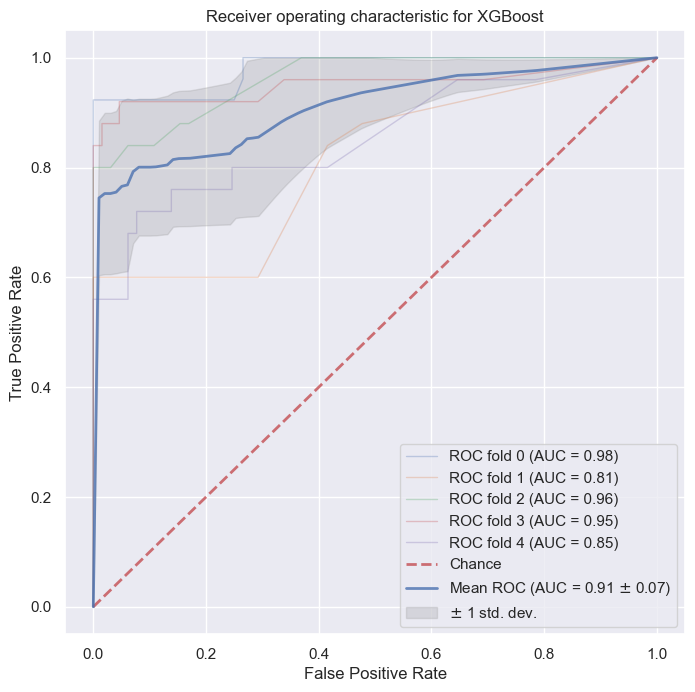

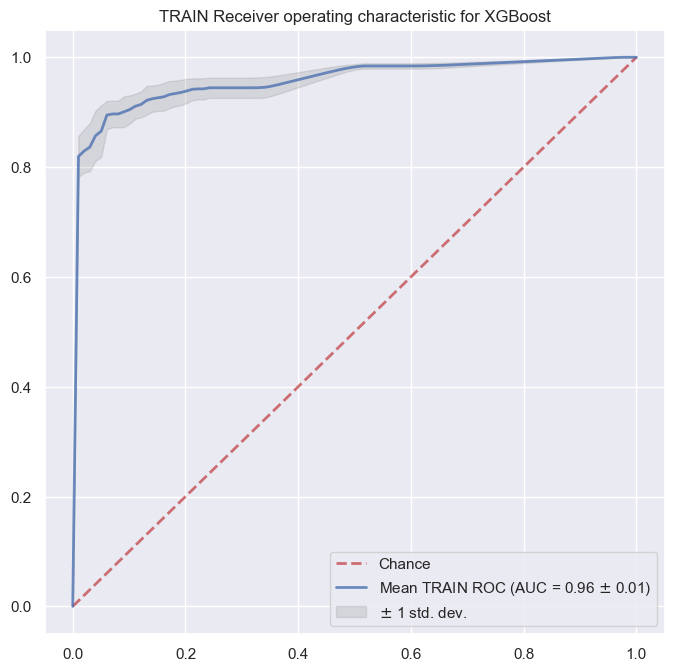

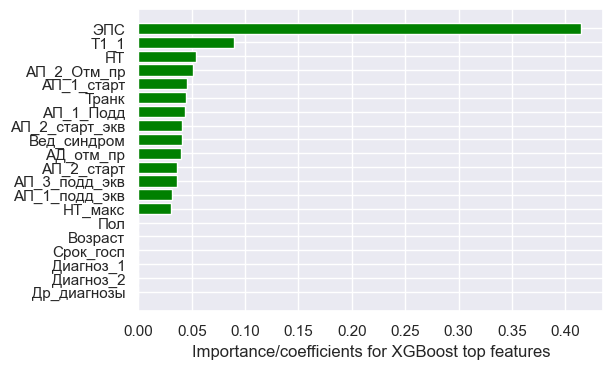

<Figure size 1000x700 with 0 Axes>

In [23]:
X_local = X
cat_cols = CATEGORICAL_COLS

classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y, name='CatBoost')
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

xg_classifier = xgb.XGBClassifier(gamma=5)

plot_roc_auc_curve(xg_classifier, cv, X_local.to_numpy(), Y, name='XGBoost')
plot_important_features(X_local, xg_classifier.feature_importances_, name='XGBoost top features')


# Trying different features

0:	learn: 0.5814273	total: 2.36ms	remaining: 2.36ms
1:	learn: 0.5047353	total: 4.6ms	remaining: 0us
0:	learn: 0.5230804	total: 2.8ms	remaining: 2.8ms
1:	learn: 0.4882423	total: 6.59ms	remaining: 0us
0:	learn: 0.5166766	total: 7.08ms	remaining: 7.08ms
1:	learn: 0.4921412	total: 10.4ms	remaining: 0us
0:	learn: 0.5088803	total: 4.12ms	remaining: 4.12ms
1:	learn: 0.4920444	total: 8.78ms	remaining: 0us
0:	learn: 0.4762667	total: 2.41ms	remaining: 2.41ms
1:	learn: 0.4490273	total: 5.18ms	remaining: 0us


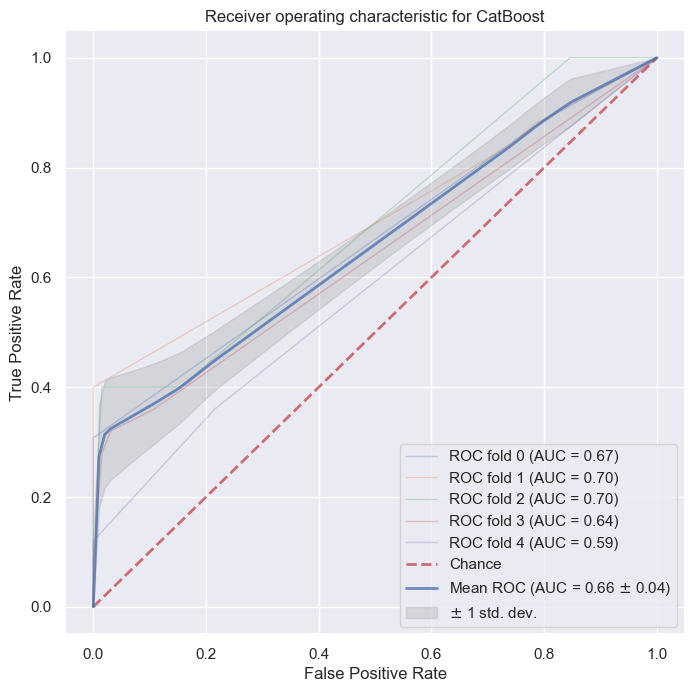

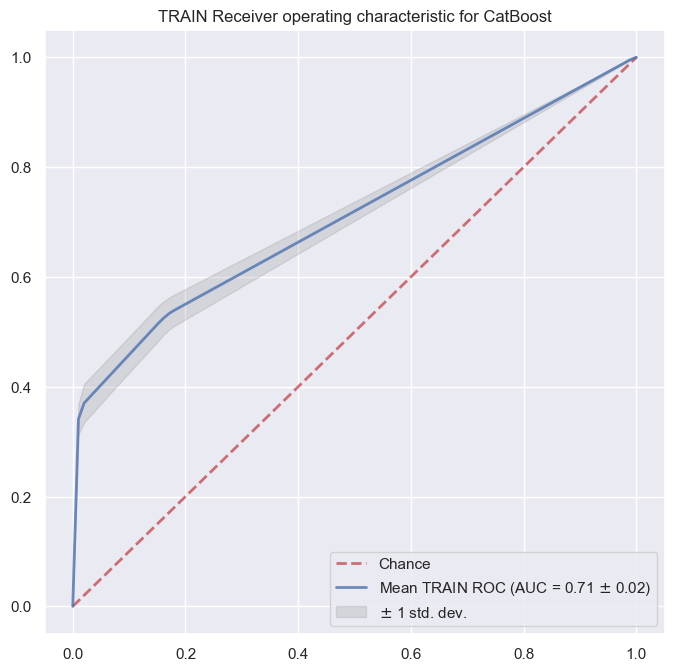

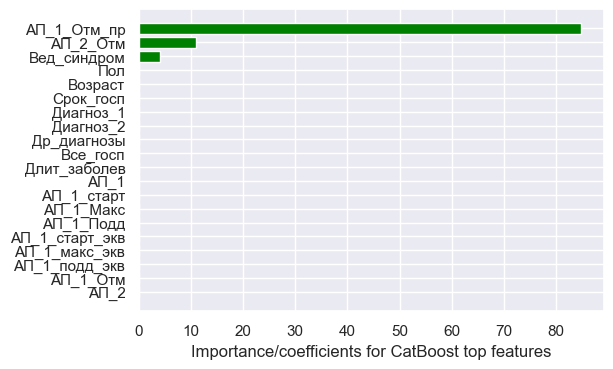

<Figure size 1000x700 with 0 Axes>

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


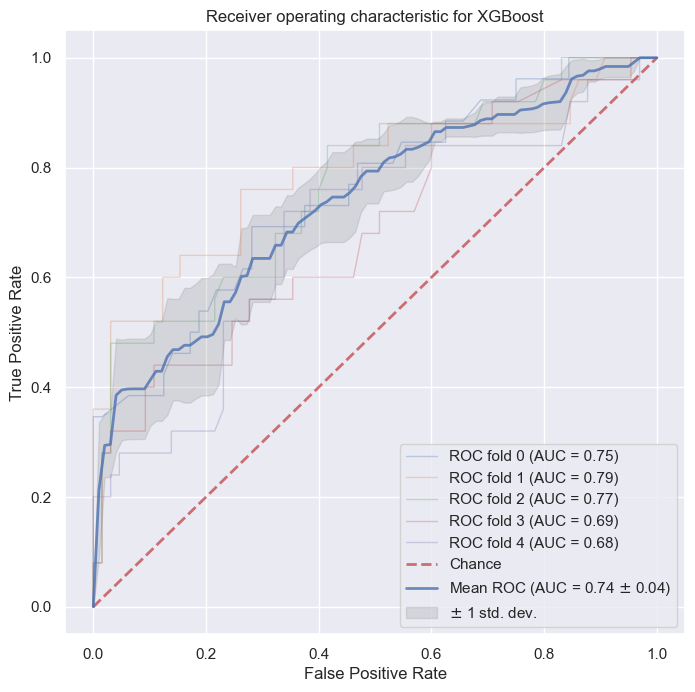

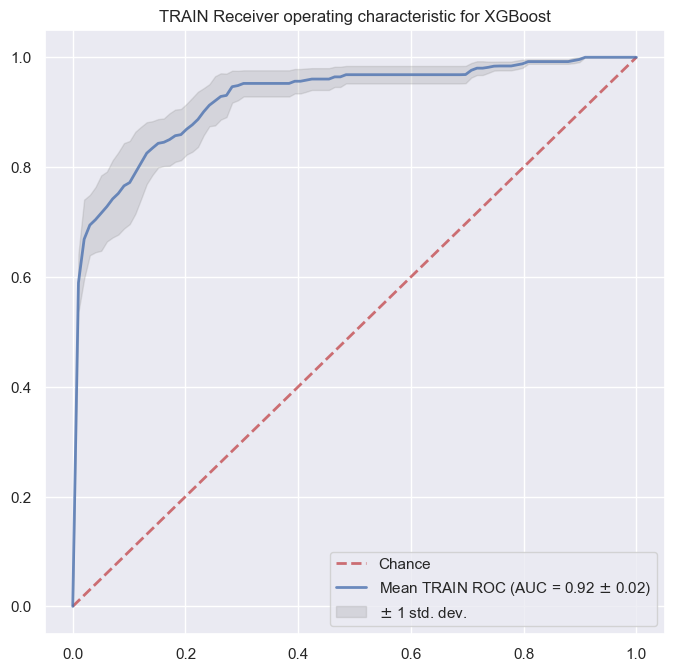

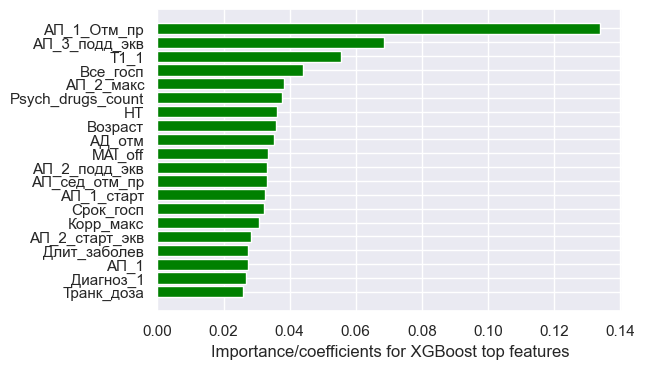

<Figure size 1000x700 with 0 Axes>

In [24]:
columns_to_remove = np.array([
    'ЭПС',
    'ЭПС_причина',
    'ЭПС_Вред_НПР',
    'ЭПС_Предотвр_НПР',
    'ЭПС_Тип_НПР',
    'ЭПС_Шкала_Наранжо',
])
cat_cols = np.setdiff1d(CATEGORICAL_COLS, columns_to_remove)
X_local = X.drop(columns=columns_to_remove)


classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y, name='CatBoost')
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')


xg_classifier = xgb.XGBClassifier(gamma=5)

plot_roc_auc_curve(xg_classifier, cv, X_local.to_numpy(), Y, name='XGBoost')
plot_important_features(X_local, xg_classifier.feature_importances_, name='XGBoost top features')

# Prediction by drugs count

0:	learn: 0.5693362	total: 606us	remaining: 606us
1:	learn: 0.5616206	total: 1.2ms	remaining: 0us
0:	learn: 0.5675444	total: 1.92ms	remaining: 1.92ms
1:	learn: 0.5580735	total: 2.41ms	remaining: 0us
0:	learn: 0.5627393	total: 326us	remaining: 326us
1:	learn: 0.5517620	total: 764us	remaining: 0us
0:	learn: 0.5672762	total: 511us	remaining: 511us
1:	learn: 0.5577016	total: 986us	remaining: 0us
0:	learn: 0.5535971	total: 407us	remaining: 407us
1:	learn: 0.5382669	total: 828us	remaining: 0us


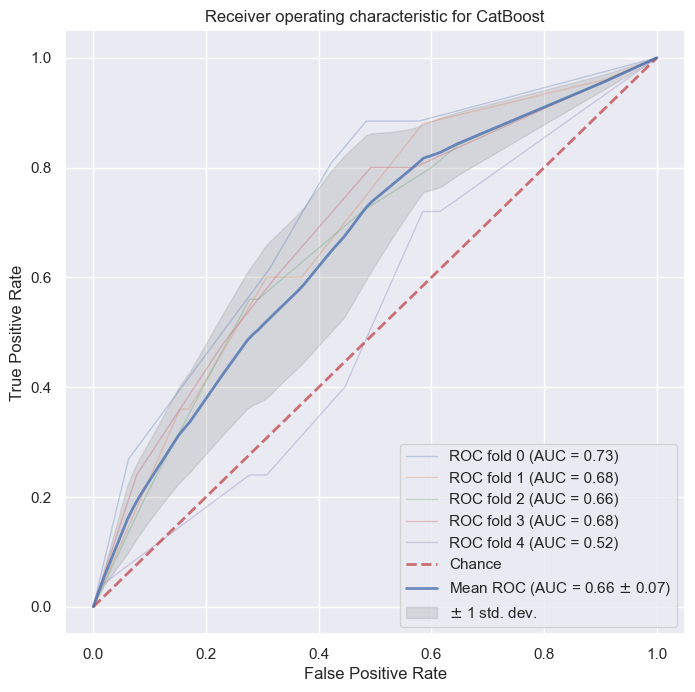

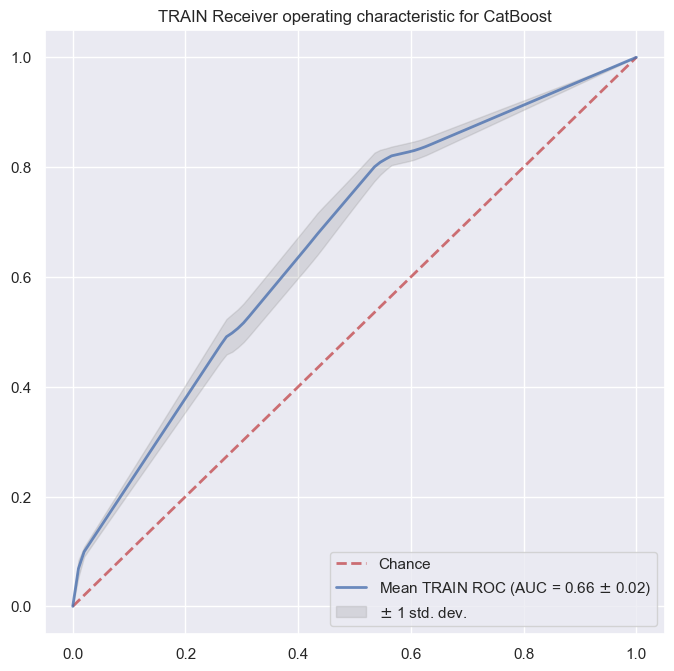

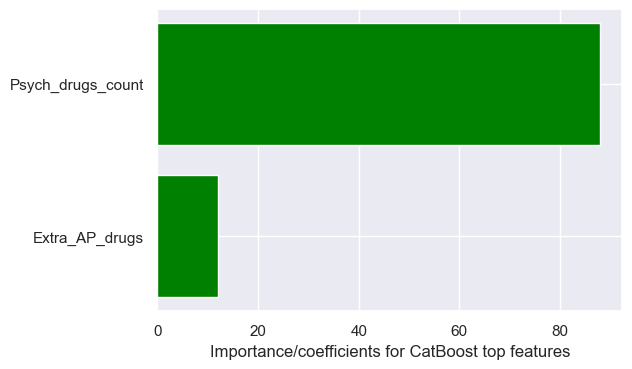

<Figure size 1000x700 with 0 Axes>

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/alexandershein/Co

[10:09:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:09:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:09:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:09:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


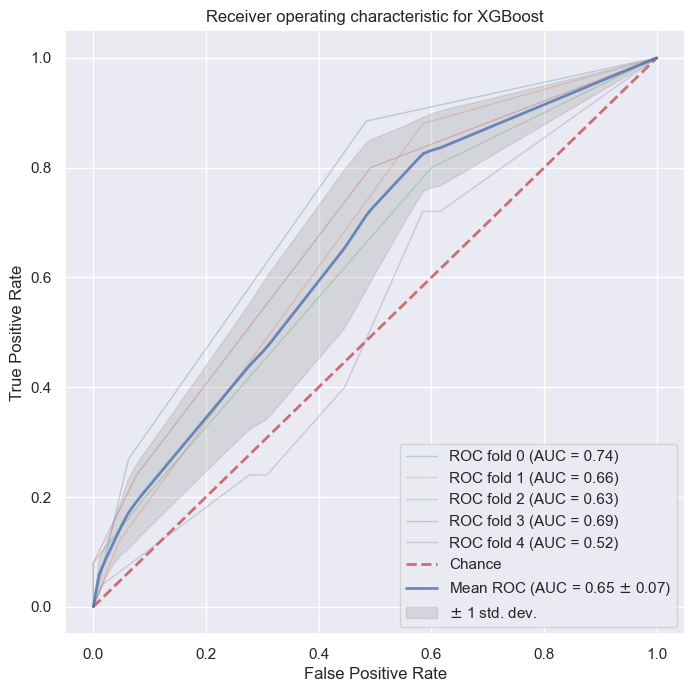

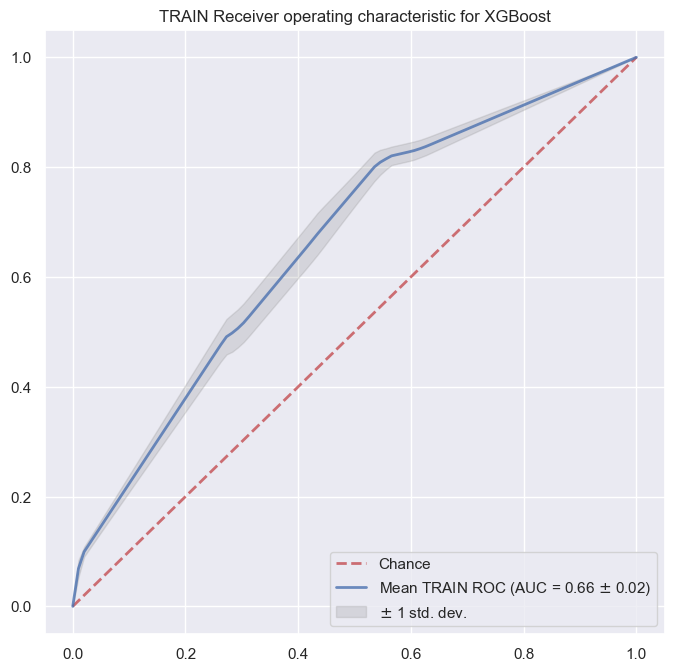

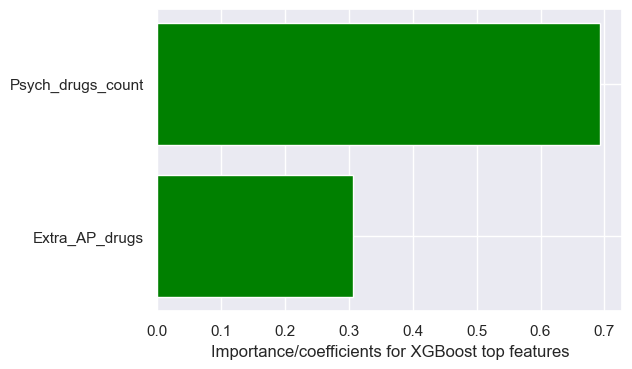

<Figure size 1000x700 with 0 Axes>

In [25]:
X_local = X[[
    'Psych_drugs_count',
    'Extra_AP_drugs',
]]

classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
#     cat_features=np.array([X.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y, name='CatBoost')
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')


xg_classifier = xgb.XGBClassifier(gamma=5)

plot_roc_auc_curve(xg_classifier, cv, X_local.to_numpy(), Y, name='XGBoost')
plot_important_features(X_local, xg_classifier.feature_importances_, name='XGBoost top features')

# Removing AP cancellation reasons cols

0:	learn: 0.5738344	total: 4.7ms	remaining: 4.7ms
1:	learn: 0.5468608	total: 7.93ms	remaining: 0us
0:	learn: 0.5459466	total: 2.6ms	remaining: 2.6ms
1:	learn: 0.5309096	total: 5.41ms	remaining: 0us
0:	learn: 0.5666038	total: 5.89ms	remaining: 5.89ms
1:	learn: 0.5507420	total: 8.95ms	remaining: 0us
0:	learn: 0.5608330	total: 2.17ms	remaining: 2.17ms
1:	learn: 0.5471770	total: 7.17ms	remaining: 0us
0:	learn: 0.5770915	total: 2.17ms	remaining: 2.17ms
1:	learn: 0.5324417	total: 4.92ms	remaining: 0us


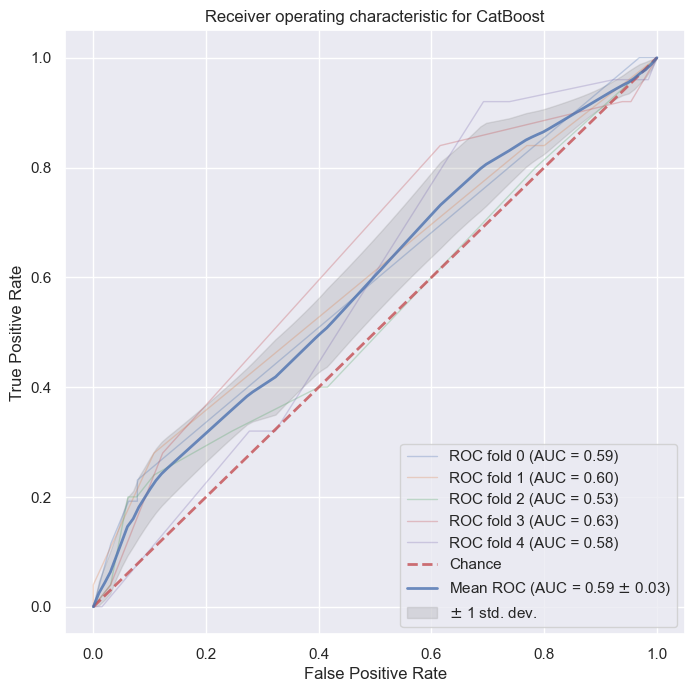

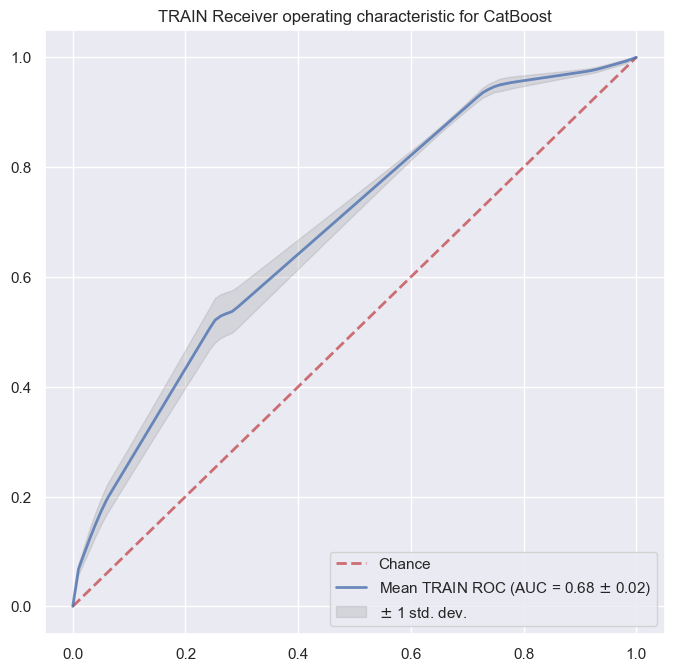

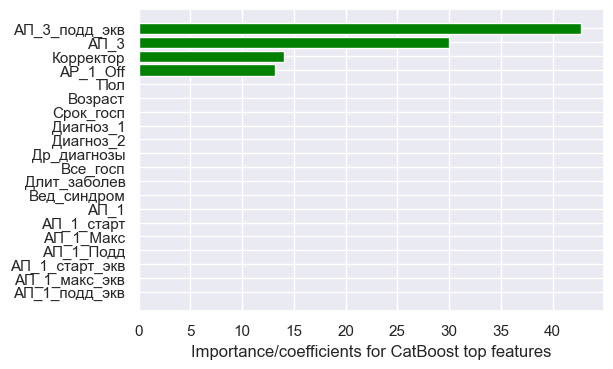

<Figure size 1000x700 with 0 Axes>

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


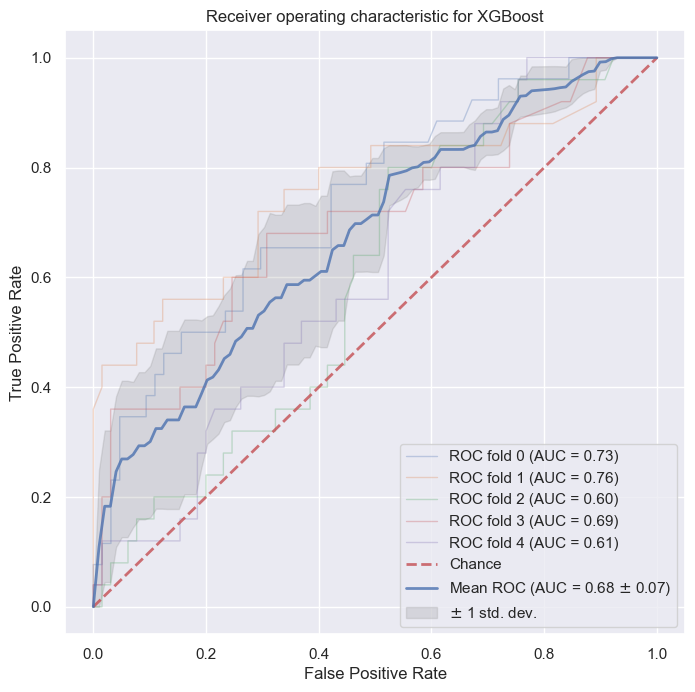

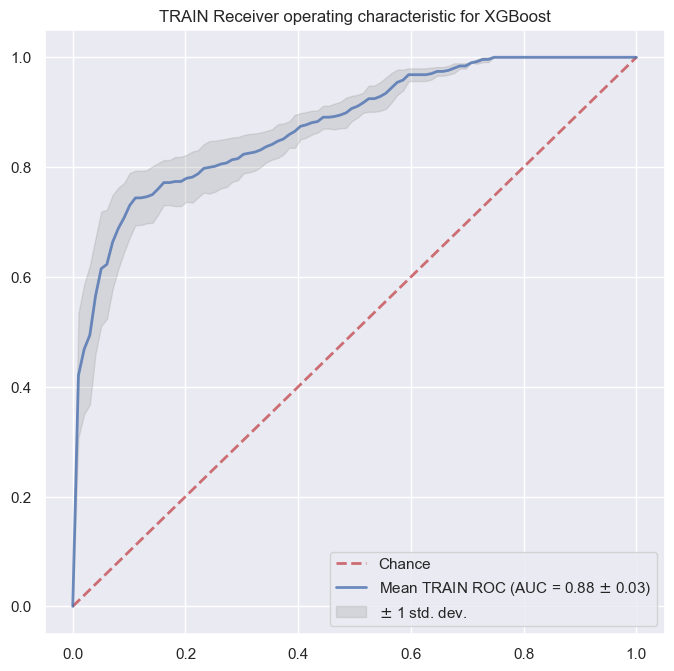

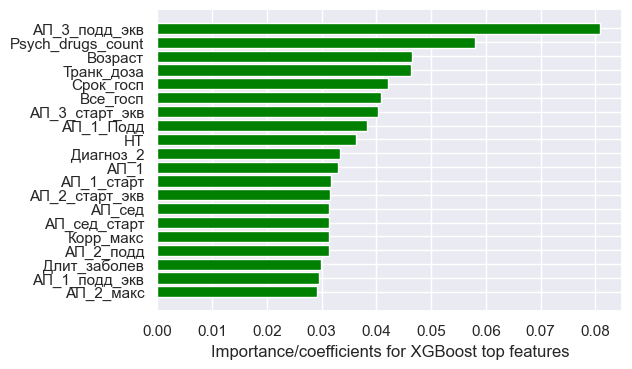

<Figure size 1000x700 with 0 Axes>

In [26]:
columns_to_remove = np.array([
    'ЭПС',
    'ЭПС_причина',
    'ЭПС_Вред_НПР',
    'ЭПС_Предотвр_НПР',
    'ЭПС_Тип_НПР',
    'ЭПС_Шкала_Наранжо',
    
    'АП_1_Отм_пр',
    'АП_2_Отм_пр',
    'АП_3_отм_пр',
])
cat_cols = np.setdiff1d(CATEGORICAL_COLS, columns_to_remove)
X_local = X.drop(columns=columns_to_remove)


classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y, name='CatBoost')
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

xg_classifier = xgb.XGBClassifier(gamma=5)

plot_roc_auc_curve(xg_classifier, cv, X_local.to_numpy(), Y, name='XGBoost')
plot_important_features(X_local, xg_classifier.feature_importances_, name='XGBoost top features')

In [27]:
pearsonr(X['Psych_drugs_count'], Y)

(0.27520936140267477, 2.9053253099539214e-09)

# Removing everything related to AP cancellation

0:	learn: 0.5630429	total: 2.95ms	remaining: 2.95ms
1:	learn: 0.5404713	total: 5.12ms	remaining: 0us
0:	learn: 0.5621707	total: 2.49ms	remaining: 2.49ms
1:	learn: 0.5350262	total: 4.94ms	remaining: 0us
0:	learn: 0.5861883	total: 4.31ms	remaining: 4.31ms
1:	learn: 0.5404795	total: 6.52ms	remaining: 0us
0:	learn: 0.5671966	total: 3.15ms	remaining: 3.15ms
1:	learn: 0.5433353	total: 5.79ms	remaining: 0us
0:	learn: 0.5606481	total: 2.06ms	remaining: 2.06ms
1:	learn: 0.5363361	total: 7.56ms	remaining: 0us


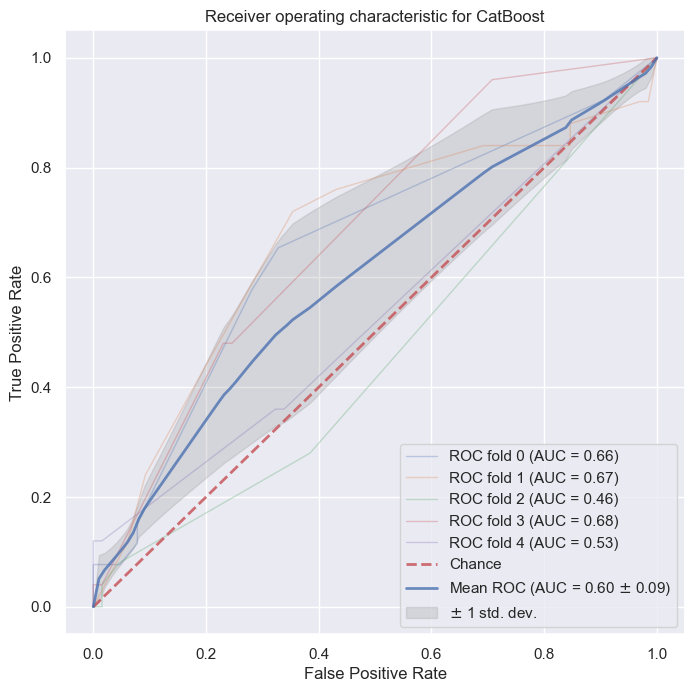

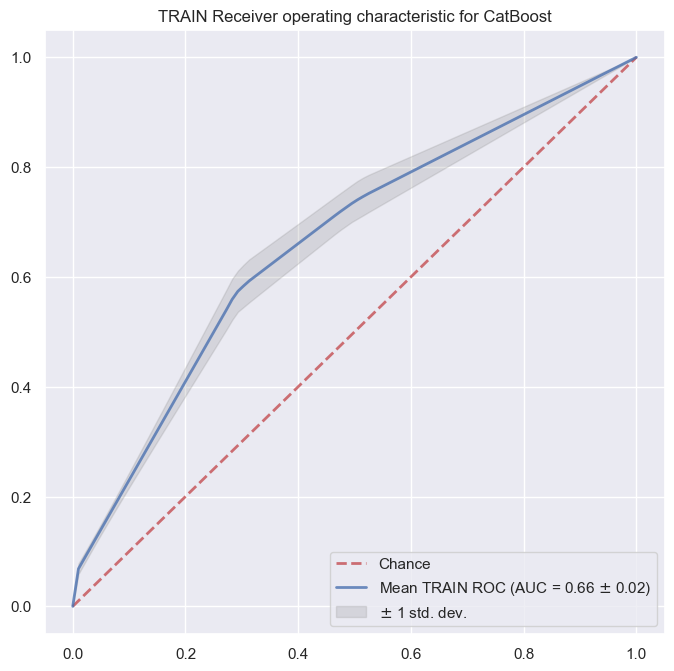

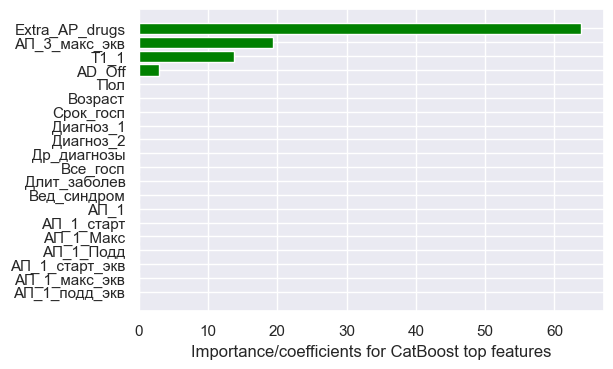

<Figure size 1000x700 with 0 Axes>

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:09:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


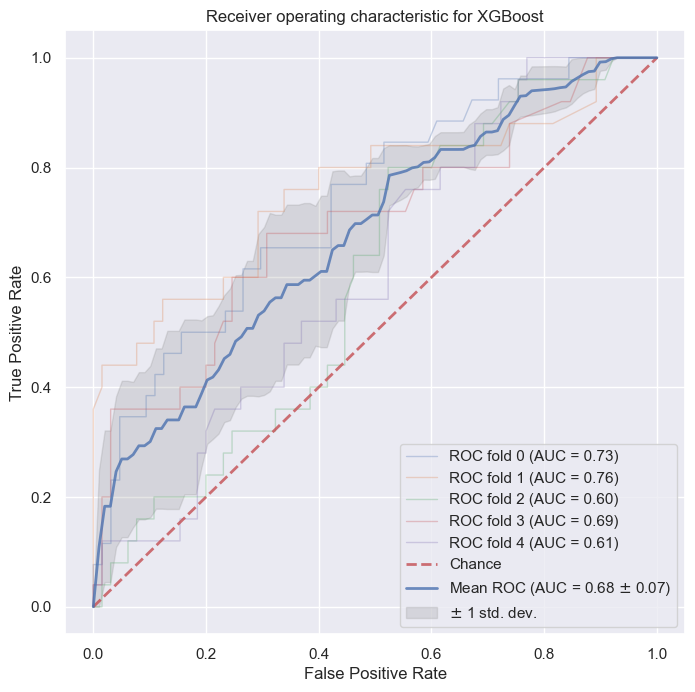

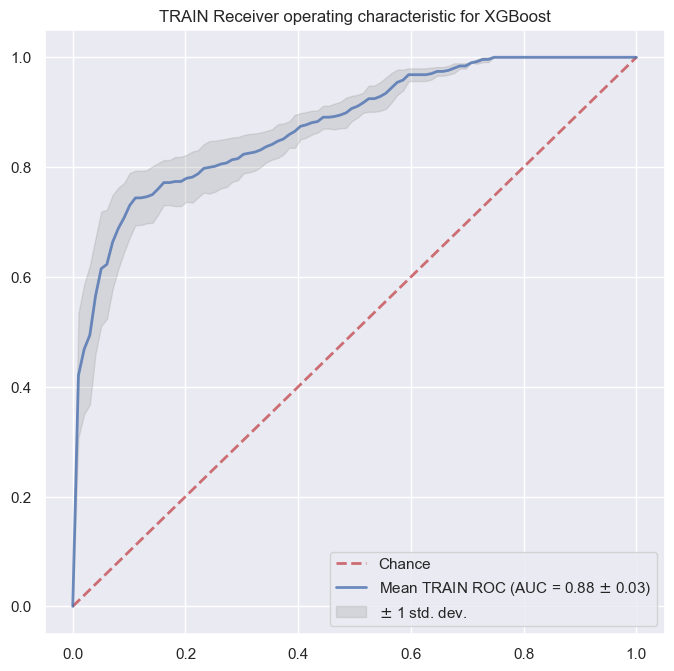

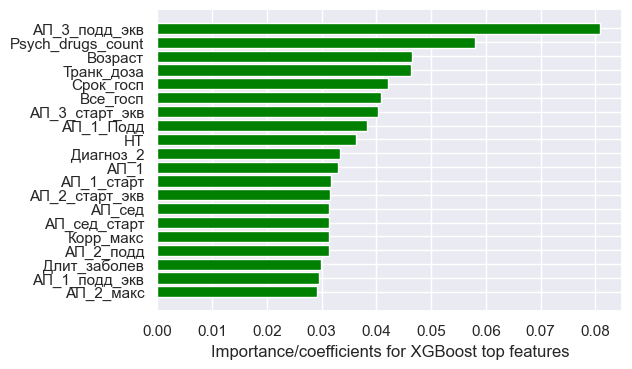

<Figure size 1000x700 with 0 Axes>

In [28]:
columns_to_remove = np.array([
    'ЭПС',
    'ЭПС_причина',
    'ЭПС_Вред_НПР',
    'ЭПС_Предотвр_НПР',
    'ЭПС_Тип_НПР',
    'ЭПС_Шкала_Наранжо',    
    'АП_1_Отм_пр',
    'АП_2_Отм_пр',
    'АП_3_отм_пр',
    'АП_1_Отм',
    'АП_2_Отм',
    'АП_3_отм',
])
cat_cols = np.setdiff1d(CATEGORICAL_COLS, columns_to_remove)
X_local = X.drop(columns=columns_to_remove)


classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y, name='CatBoost')
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

xg_classifier = xgb.XGBClassifier(gamma=5)

plot_roc_auc_curve(xg_classifier, cv, X_local.to_numpy(), Y, name='XGBoost')
plot_important_features(X_local, xg_classifier.feature_importances_, name='XGBoost top features')

In [29]:
pearsonr(X['AP_1_Off'], Y)

(-0.11819045624983646, 0.012106506283786908)

# Leaving only binary fields + Age and selected continuous ones

In [30]:
BINARY_COLUMNS = [col for col in X.columns if X[col].nunique() == 2]

EXTRA_COLUMNS = [
    'Возраст',
    'Срок_госп',
    'Все_госп',
    'Длит_заболев',
]

COLUMNS_TO_REMOVE = [
    'ЭПС_Тип_НПР',
    'ЭПС_Предотвр_НПР',
    'ЭПС_Вред_НПР',
    'Extra_AP_drugs'
]

In [31]:
BINARY_COLUMNS

['Пол',
 'MAI_major',
 'MAI_dubl',
 'Off_Label_Cat',
 'Т4_причина',
 'T12',
 'T16',
 'T17',
 'ЭПС_Вред_НПР',
 'ЭПС_Предотвр_НПР',
 'ЭПС_Тип_НПР',
 'АП_1_Тип',
 'AP_1_Off',
 'AP_2_Off',
 'AP_3_Off',
 'NT_Off',
 'AD_Off',
 'Extra_AP_drugs']

In [32]:
pearsonr(X['ЭПС_Тип_НПР'], Y)

(0.8017837257372731, 3.2215725452965996e-102)

In [33]:
pearsonr(X['ЭПС_Предотвр_НПР'], Y)

(0.8017837257372731, 3.2215725452965996e-102)

In [34]:
pearsonr(X['ЭПС_Вред_НПР'], Y)

(0.8017837257372731, 3.2215725452965996e-102)

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.5898106	total: 645us	remaining: 645us
1:	learn: 0.5701547	total: 3.75ms	remaining: 0us
0:	learn: 0.5892062	total: 7.57ms	remaining: 7.57ms
1:	learn: 0.5664090	total: 8.18ms	remaining: 0us
0:	learn: 0.5858728	total: 680us	remaining: 680us
1:	learn: 0.5671671	total: 1.58ms	remaining: 0us
0:	learn: 0.5898349	total: 2.77ms	remaining: 2.77ms
1:	learn: 0.5619758	total: 3.23ms	remaining: 0us
0:	learn: 0.5871864	total: 435us	remaining: 435us
1:	learn: 0.5652997	total: 872us	remaining: 0us


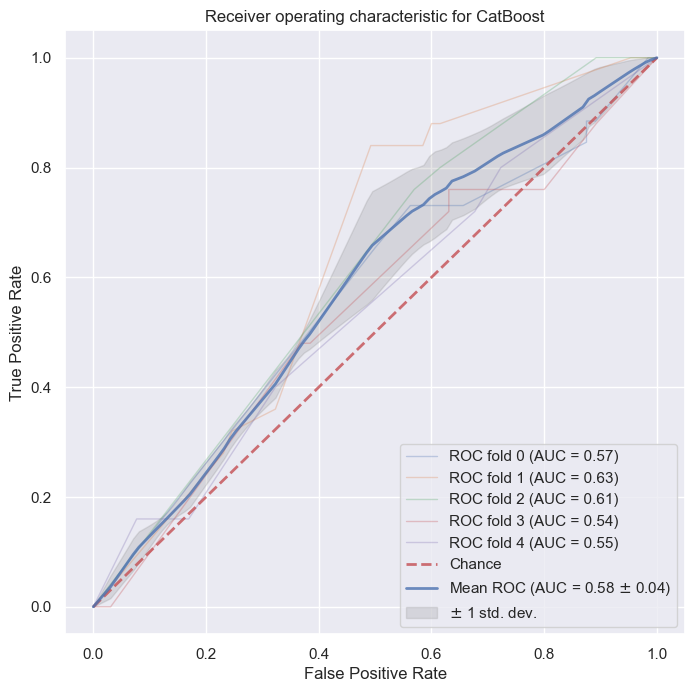

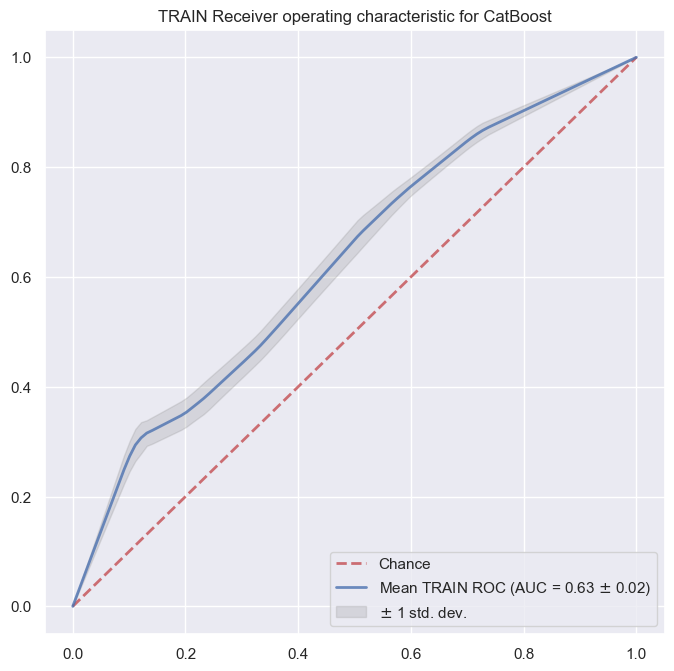

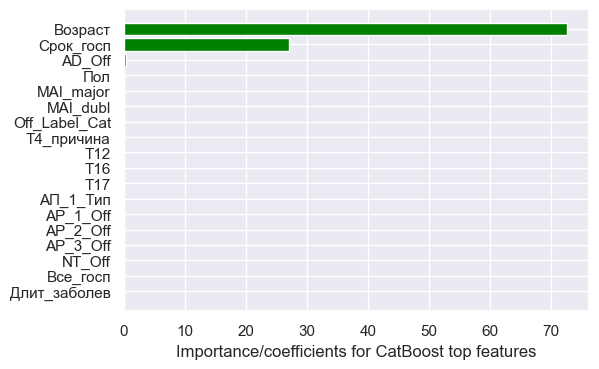

<Figure size 1000x700 with 0 Axes>

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:10:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:10:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


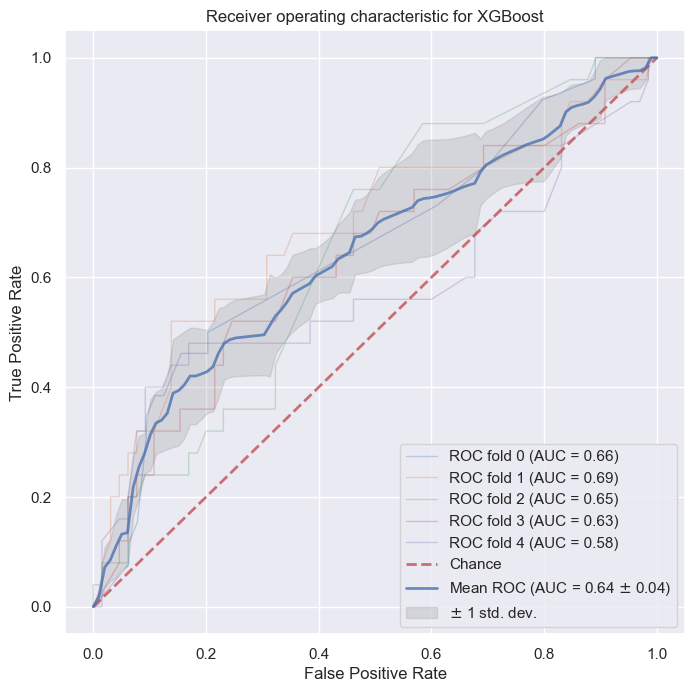

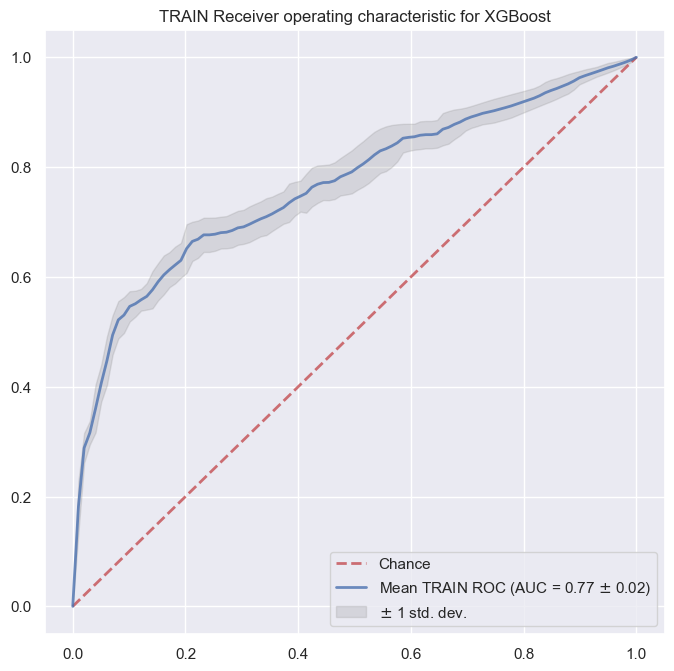

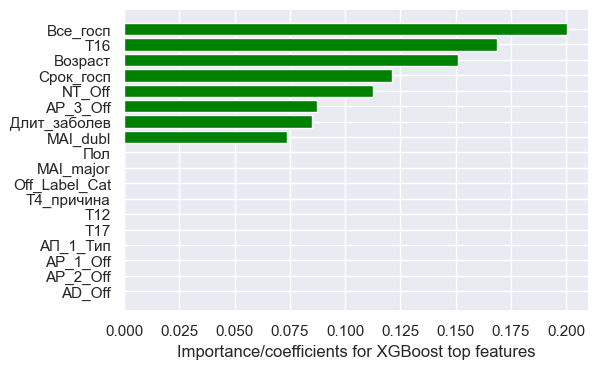

<Figure size 1000x700 with 0 Axes>

In [35]:
cat_cols = np.setdiff1d(BINARY_COLUMNS, COLUMNS_TO_REMOVE)
X_local = X[BINARY_COLUMNS + EXTRA_COLUMNS]

X_local[BINARY_COLUMNS] = X_local[BINARY_COLUMNS].astype(bool)
X_local = X_local.drop(columns=COLUMNS_TO_REMOVE)

classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y, name='CatBoost')
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

xg_classifier = xgb.XGBClassifier(gamma=5)

plot_roc_auc_curve(xg_classifier, cv, X_local.to_numpy(), Y, name='XGBoost')
plot_important_features(X_local, xg_classifier.feature_importances_, name='XGBoost top features')

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.5808992	total: 580us	remaining: 580us
1:	learn: 0.5725660	total: 2.66ms	remaining: 0us
0:	learn: 0.5773143	total: 370us	remaining: 370us
1:	learn: 0.5606402	total: 1.22ms	remaining: 0us
0:	learn: 0.5838698	total: 892us	remaining: 892us
1:	learn: 0.5680633	total: 1.47ms	remaining: 0us
0:	learn: 0.5737997	total: 467us	remaining: 467us
1:	learn: 0.5631742	total: 1.91ms	remaining: 0us
0:	learn: 0.5819630	total: 310us	remaining: 310us
1:	learn: 0.5700731	total: 750us	remaining: 0us


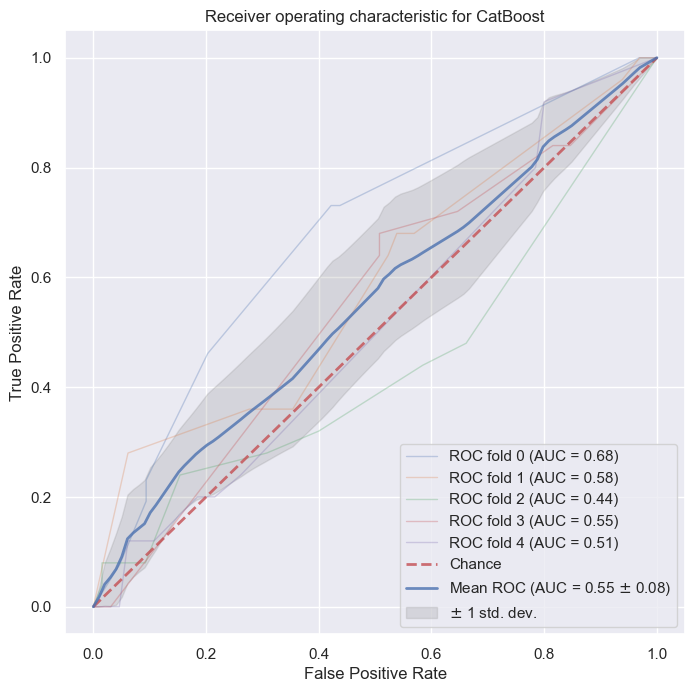

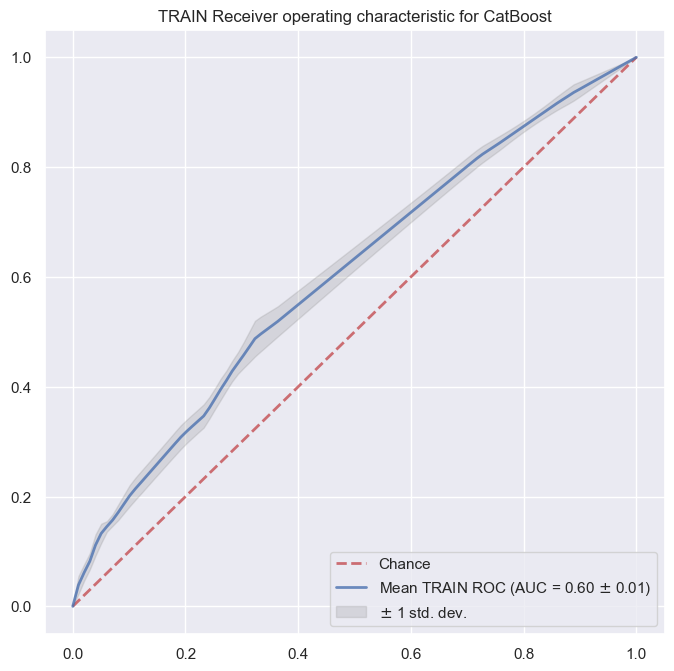

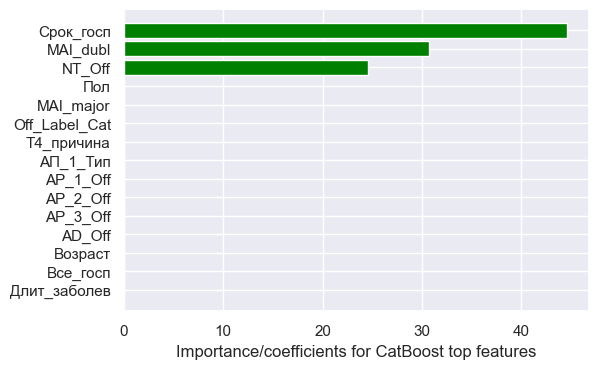

<Figure size 1000x700 with 0 Axes>

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


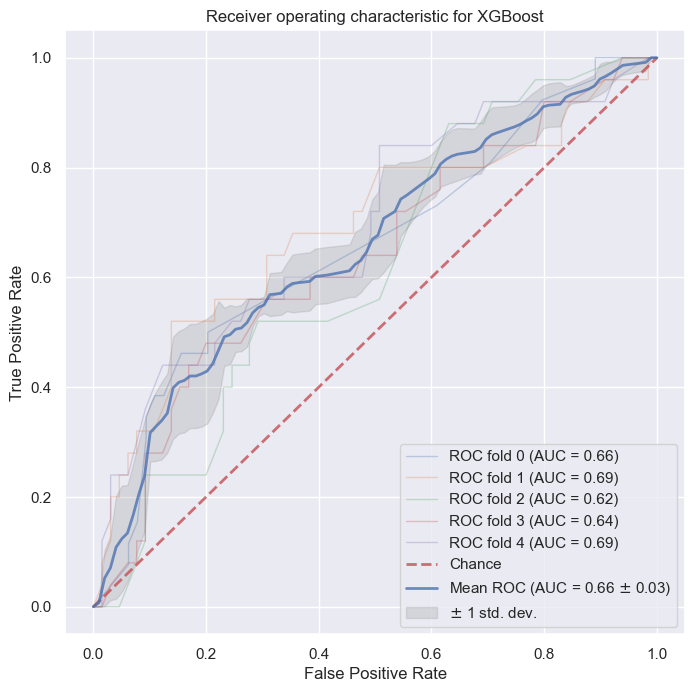

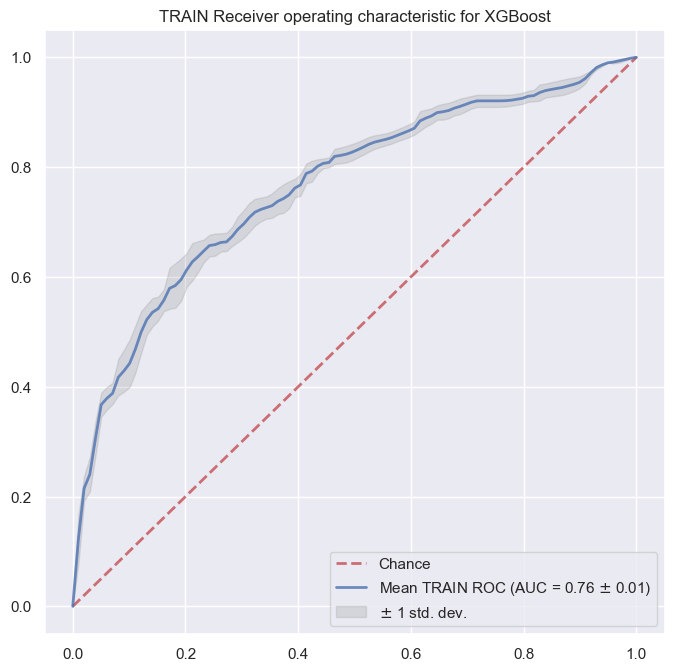

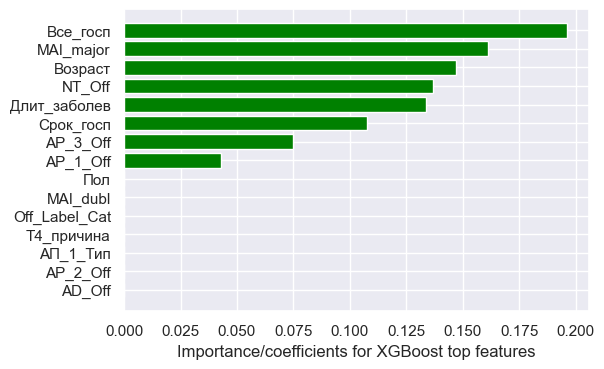

<Figure size 1000x700 with 0 Axes>

In [36]:
BINARY_COLUMNS = [col for col in X.columns if X[col].nunique() == 2]

EXTRA_COLUMNS = [
    'Возраст',
    'Срок_госп',
    'Все_госп',
    'Длит_заболев',
]

COLUMNS_TO_REMOVE = [
    'ЭПС_Тип_НПР',
    'ЭПС_Предотвр_НПР',
    'ЭПС_Вред_НПР',
    'Extra_AP_drugs',
    'T12',
    'T16',
    'T17',
    
]
cat_cols = np.setdiff1d(BINARY_COLUMNS, COLUMNS_TO_REMOVE)
X_local = X[BINARY_COLUMNS + EXTRA_COLUMNS]

X_local[BINARY_COLUMNS] = X_local[BINARY_COLUMNS].astype(bool)
X_local = X_local.drop(columns=COLUMNS_TO_REMOVE)

classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y, name='CatBoost')
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

xg_classifier = xgb.XGBClassifier(gamma=5)

plot_roc_auc_curve(xg_classifier, cv, X_local.to_numpy(), Y, name='XGBoost')
plot_important_features(X_local, xg_classifier.feature_importances_, name='XGBoost top features')

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	learn: 0.5932922	total: 317us	remaining: 317us
1:	learn: 0.5673042	total: 908us	remaining: 0us
0:	learn: 0.5855608	total: 553us	remaining: 553us
1:	learn: 0.5688050	total: 2.83ms	remaining: 0us
0:	learn: 0.5927987	total: 684us	remaining: 684us
1:	learn: 0.5766753	total: 958us	remaining: 0us
0:	learn: 0.5879257	total: 325us	remaining: 325us
1:	learn: 0.5656334	total: 895us	remaining: 0us
0:	learn: 0.5913236	total: 296us	remaining: 296us
1:	learn: 0.5582582	total: 942us	remaining: 0us


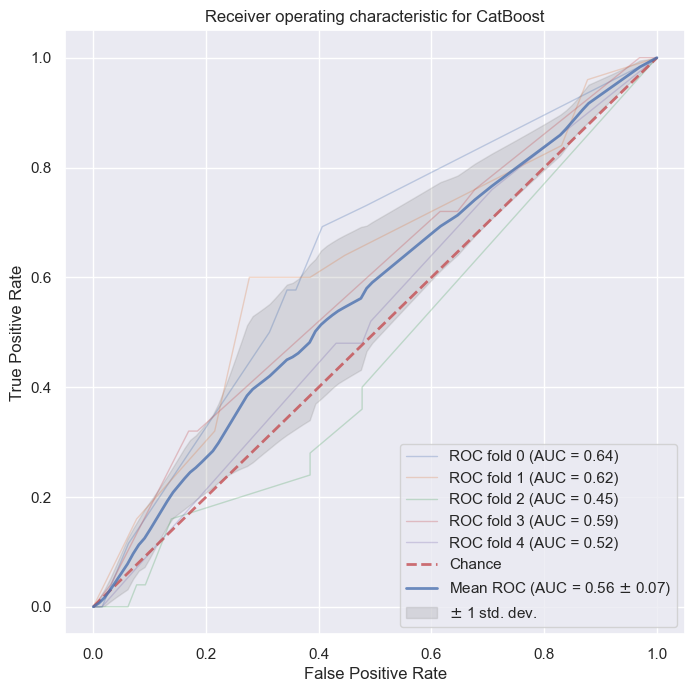

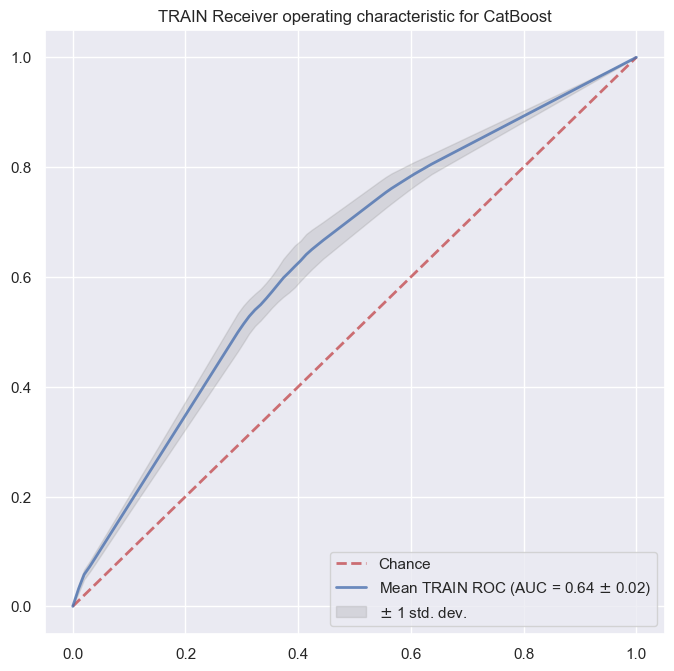

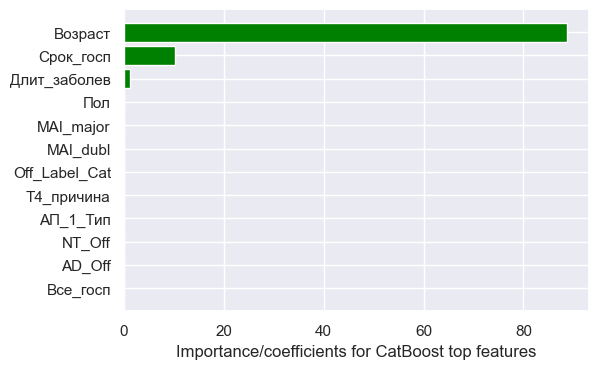

<Figure size 1000x700 with 0 Axes>

/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:10:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alexandershein/Code/study/bioinf_covid/env/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


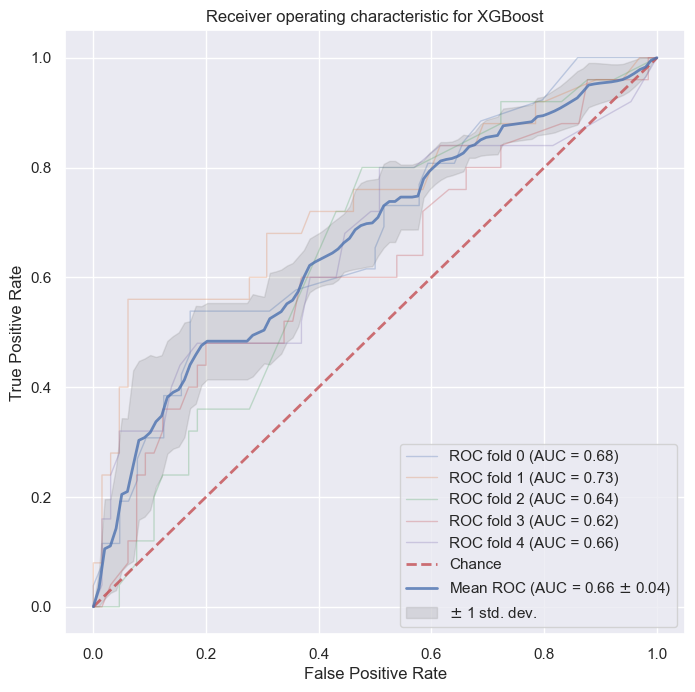

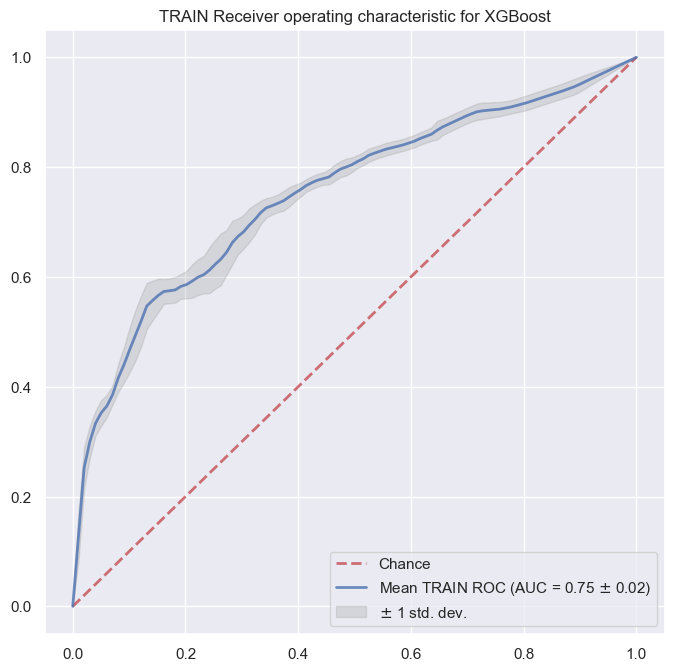

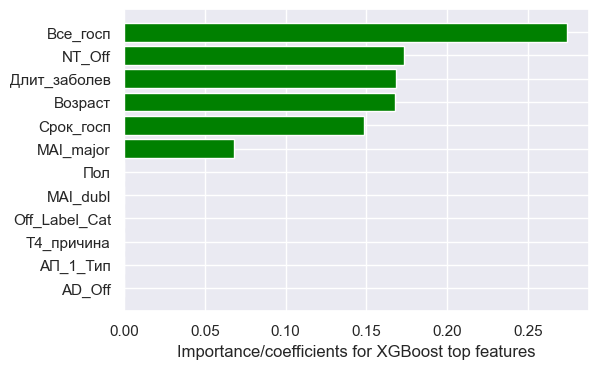

<Figure size 1000x700 with 0 Axes>

In [37]:
BINARY_COLUMNS = [col for col in X.columns if X[col].nunique() == 2]

EXTRA_COLUMNS = [
    'Возраст',
    'Срок_госп',
    'Все_госп',
    'Длит_заболев',
]

COLUMNS_TO_REMOVE = [
    'ЭПС_Тип_НПР',
    'ЭПС_Предотвр_НПР',
    'ЭПС_Вред_НПР',
    'Extra_AP_drugs',
    'T12',
    'T16',
    'T17',
    'AP_3_Off',
    'AP_1_Off',
    'AP_2_Off',
    
]
cat_cols = np.setdiff1d(BINARY_COLUMNS, COLUMNS_TO_REMOVE)
X_local = X[BINARY_COLUMNS + EXTRA_COLUMNS]

X_local[BINARY_COLUMNS] = X_local[BINARY_COLUMNS].astype(bool)
X_local = X_local.drop(columns=COLUMNS_TO_REMOVE)

classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
    cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)

plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y, name='CatBoost')
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

xg_classifier = xgb.XGBClassifier(gamma=5)

plot_roc_auc_curve(xg_classifier, cv, X_local.to_numpy(), Y, name='XGBoost')
plot_important_features(X_local, xg_classifier.feature_importances_, name='XGBoost top features')

In [170]:
[col for col in X_local if X_local[col].isna().any()]

['Disease duration']

Sex  MAI_major  MAI_dubl  Off_Label_Cat  АP_1_type   Age  \
0    True       True      True           True       True  17.0   
1    True       True      True           True       True  15.0   
2    True       True      True          False       True  14.0   
3    True       True      True          False       True  14.0   
4    True       True     False           True       True   8.0   
..    ...        ...       ...            ...        ...   ...   
441  True      False     False          False       True  17.0   
442  True       True     False          False       True  15.0   
443  True      False     False          False       True  15.0   
444  True       True     False           True       True  15.0   
445  True       True     False          False       True   9.0   

     Admission duration  Number of admissions  Disease duration  MAI  
0                  65.0                   2.0              36.0  3.0  
1                 202.0                   1.0               0.0  3.0  
2                  89.0                   1.0               1.0  3.0  
3                  60.0                   1.0               2.0  3.0  
4                  24.0                   2.0              15.0  2.0  
..                  ...                   ...               ...  ...  
441                31.0                   1.0              14.0  0.0  
442                32.0                   1.0               2.0  2.0  
443                39.0                   1.0               8.0  0.0  
444                29.0                   2.0              12.0  2.0  
445                56.0                   2.0              72.0  2.0  

[276 rows x 10 columns]

In [189]:
# ?RandomForestClassifier
# ?StratifiedKFold

0:	learn: 0.5918386	total: 3.8ms	remaining: 3.8ms
1:	learn: 0.5834981	total: 4.93ms	remaining: 0us
0:	learn: 0.5889772	total: 882us	remaining: 882us
1:	learn: 0.5783989	total: 1.26ms	remaining: 0us
0:	learn: 0.5868109	total: 963us	remaining: 963us
1:	learn: 0.5657189	total: 1.76ms	remaining: 0us
0:	learn: 0.5916152	total: 442us	remaining: 442us
1:	learn: 0.5762694	total: 931us	remaining: 0us
0:	learn: 0.5819900	total: 299us	remaining: 299us
1:	learn: 0.5689771	total: 736us	remaining: 0us


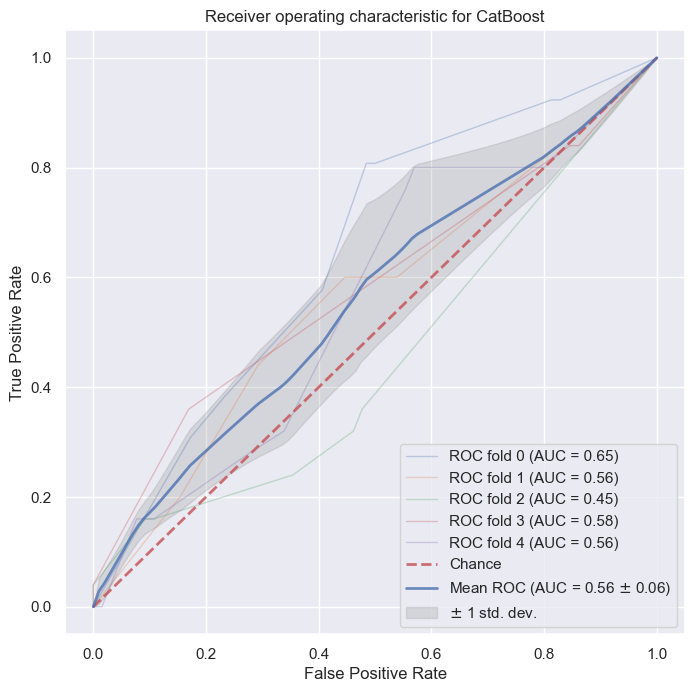

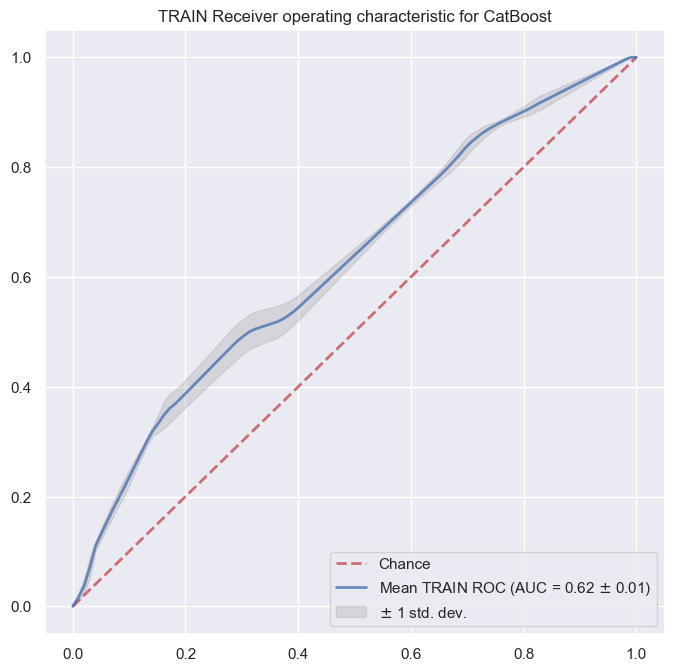

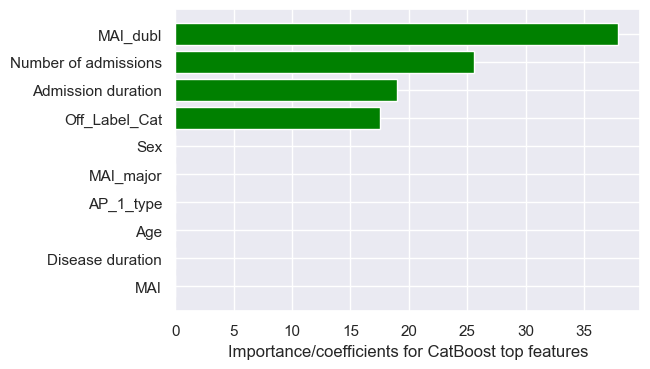

<Figure size 1000x700 with 0 Axes>

[22:17:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

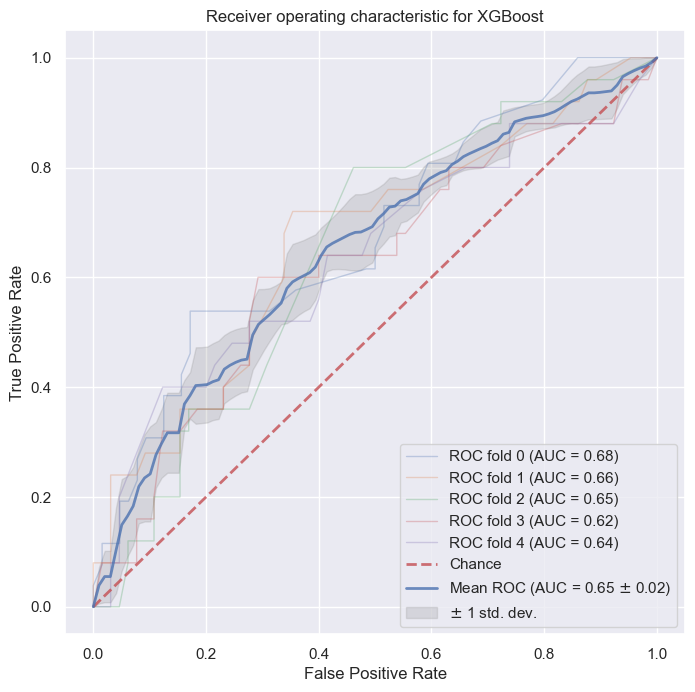

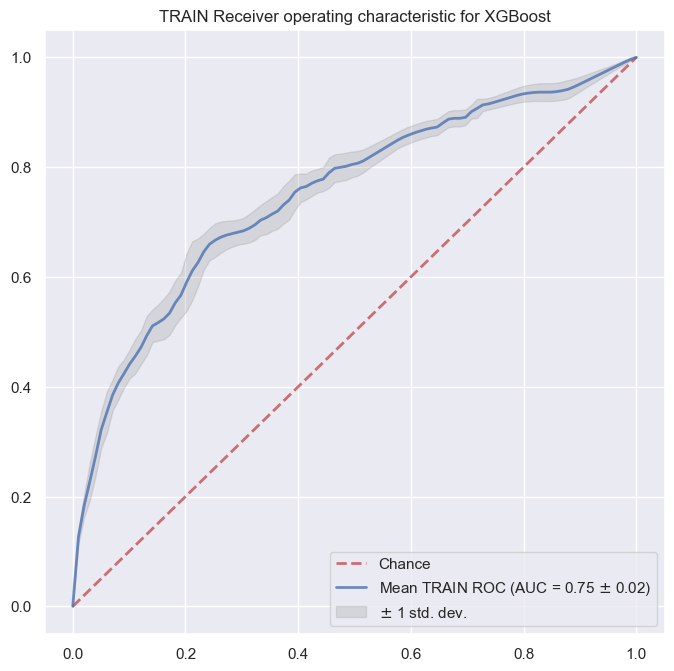

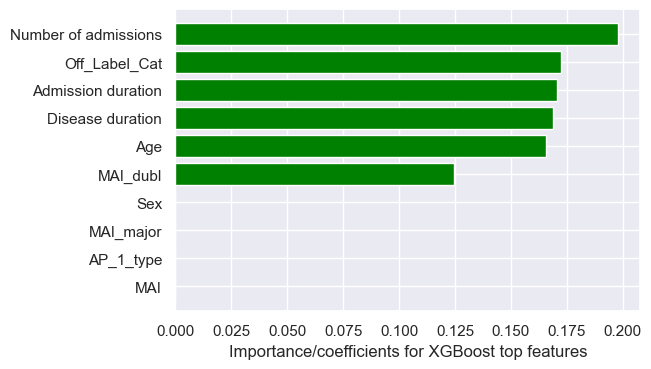

<Figure size 1000x700 with 0 Axes>

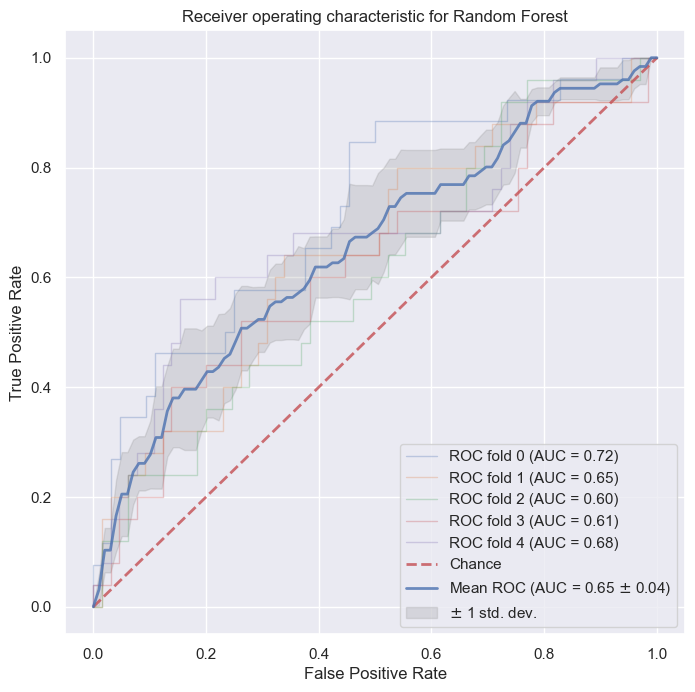

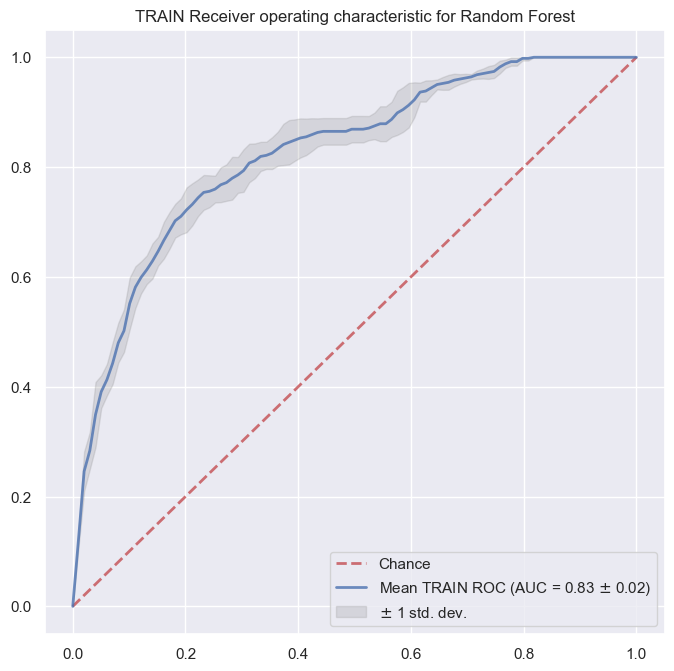

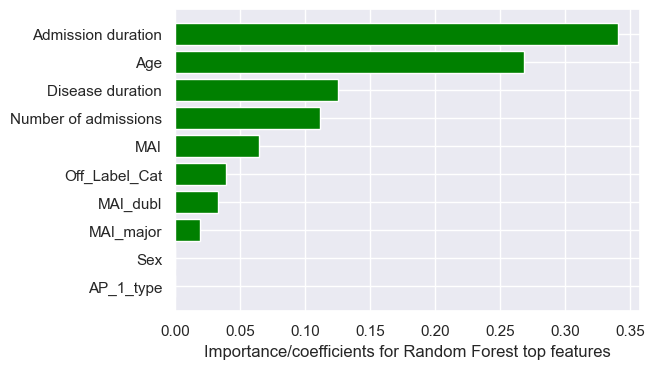

<Figure size 1000x700 with 0 Axes>

In [196]:
BINARY_COLUMNS = [col for col in X.columns if X[col].nunique() == 2]

EXTRA_COLUMNS = [
    'Возраст',
    'Срок_госп',
    'Все_госп',
    'Длит_заболев',
    'MAI',
]

COLUMNS_TO_REMOVE = [
    'ЭПС_Тип_НПР',
    'ЭПС_Предотвр_НПР',
    'ЭПС_Вред_НПР',
    'Extra_AP_drugs',
    'T12',
    'T16',
    'T17',
    'AP_3_Off',
    'AP_1_Off',
    'AP_2_Off',
    'NT_Off',
    'Т4_причина',
    'AD_Off',
#     'АП_1_Тип'
    
]
# cat_cols = np.setdiff1d(BINARY_COLUMNS, COLUMNS_TO_REMOVE)
X_local = X[BINARY_COLUMNS + EXTRA_COLUMNS]

X_local[BINARY_COLUMNS] = X_local[BINARY_COLUMNS].astype(bool)
X_local = X_local.drop(columns=COLUMNS_TO_REMOVE)

X_local = X_local.rename(columns={
    'Возраст': 'Age',
    'Все_госп': 'Number of admissions',
    'Пол': 'Sex',
    'Длит_заболев': 'Disease duration',
    'Срок_госп': 'Admission duration',
    'АП_1_Тип': 'АP_1_type',
})

classifier = CatBoostClassifier(
    iterations=2,
    depth=2,
    learning_rate=1,
    loss_function='Logloss',
    verbose=True,
#     cat_features=np.array([X_local.columns.get_loc(item) for item in cat_cols]),
) 
cv = StratifiedKFold(n_splits=5)




plot_roc_auc_curve(classifier, cv, X_local.to_numpy(), Y, name='CatBoost')
plot_important_features(X_local, classifier.feature_importances_, name='CatBoost top features')

xg_classifier = xgb.XGBClassifier(gamma=5)

plot_roc_auc_curve(xg_classifier, cv, X_local.to_numpy(), Y, name='XGBoost')
plot_important_features(X_local, xg_classifier.feature_importances_, name='XGBoost top features')


X_local = X_local.fillna(0)
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=4, max_features=4)

plot_roc_auc_curve(rf_classifier, cv, X_local.to_numpy(), Y, name='Random Forest')
plot_important_features(X_local, rf_classifier.feature_importances_, name='Random Forest top features')

In [78]:
list(enumerate(X_local.columns))

[(0, 'Sex'),
 (1, 'MAI_major'),
 (2, 'MAI_dubl'),
 (3, 'Off_Label_Cat'),
 (4, 'АP_1_type'),
 (5, 'Age'),
 (6, 'Admission duration'),
 (7, 'Number of admissions'),
 (8, 'Disease duration'),
 (9, 'MAI')]

# PDP Plots

In [197]:
from pdpbox import pdp
def plot_pdp(classifier, X_local, feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(classifier, X_local, X_local.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, 
                        n_cluster_centers=clusters)

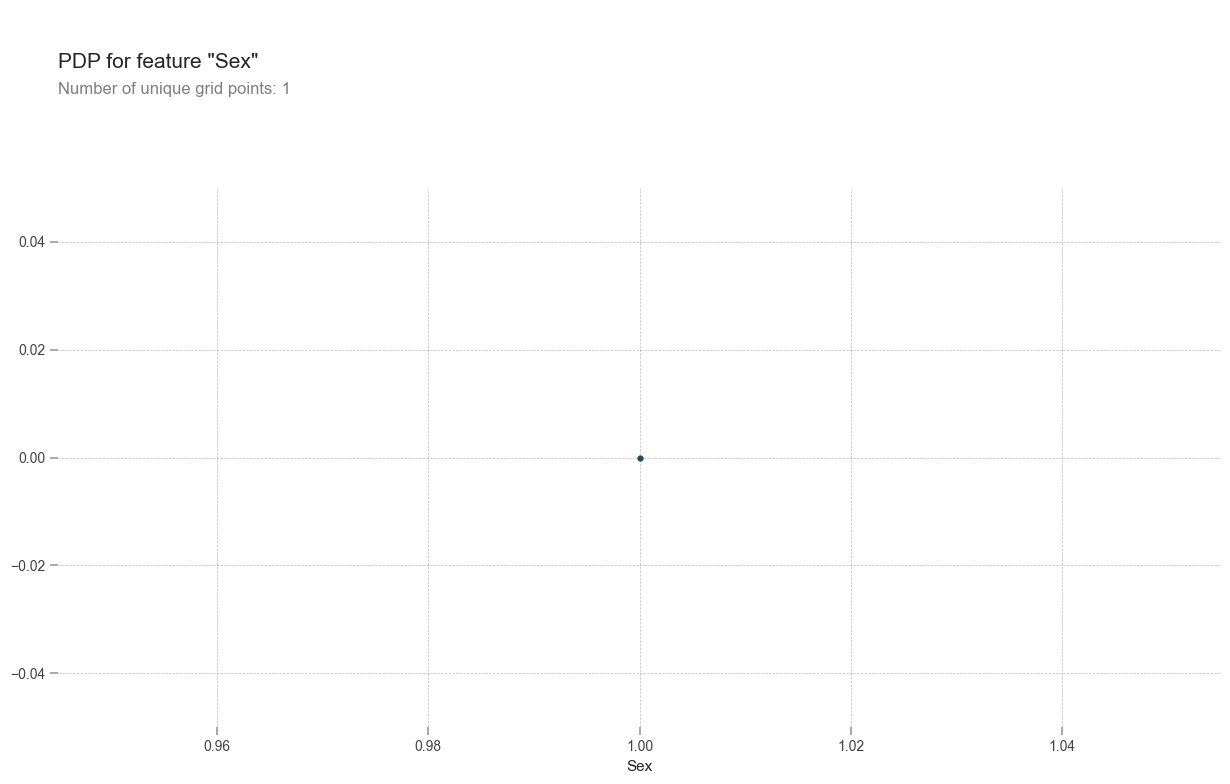

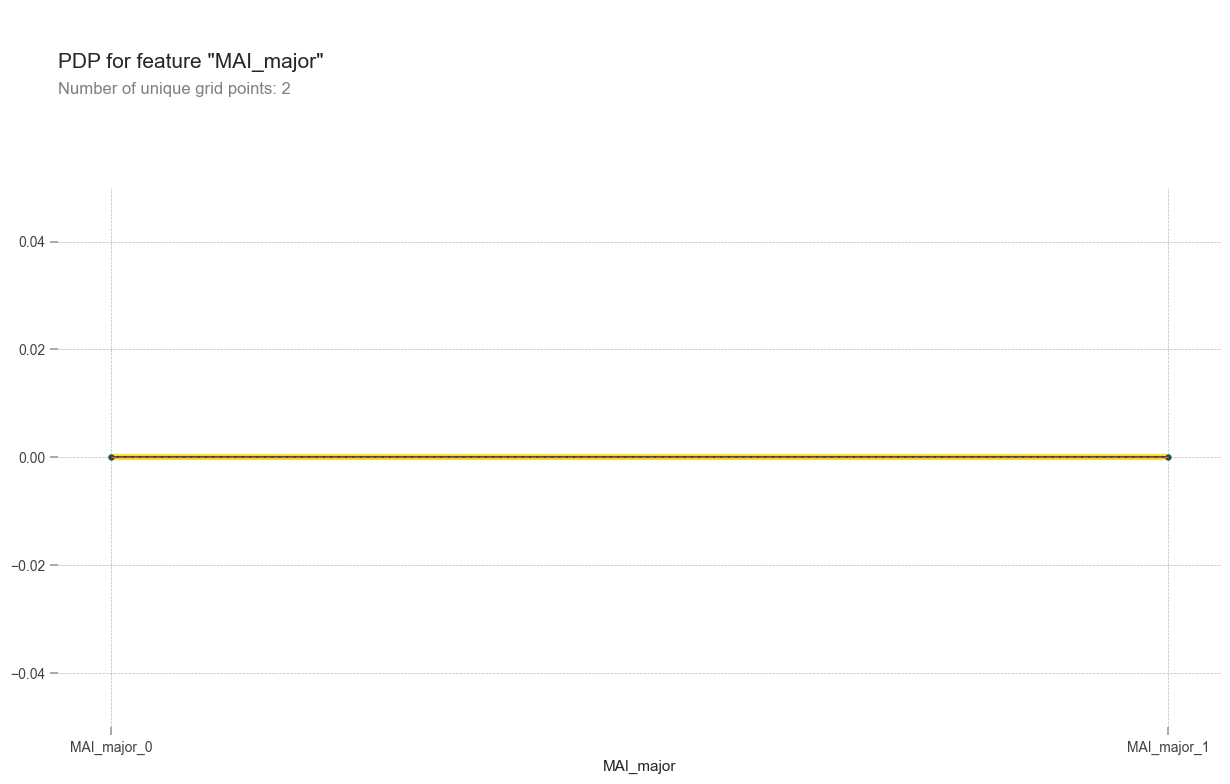

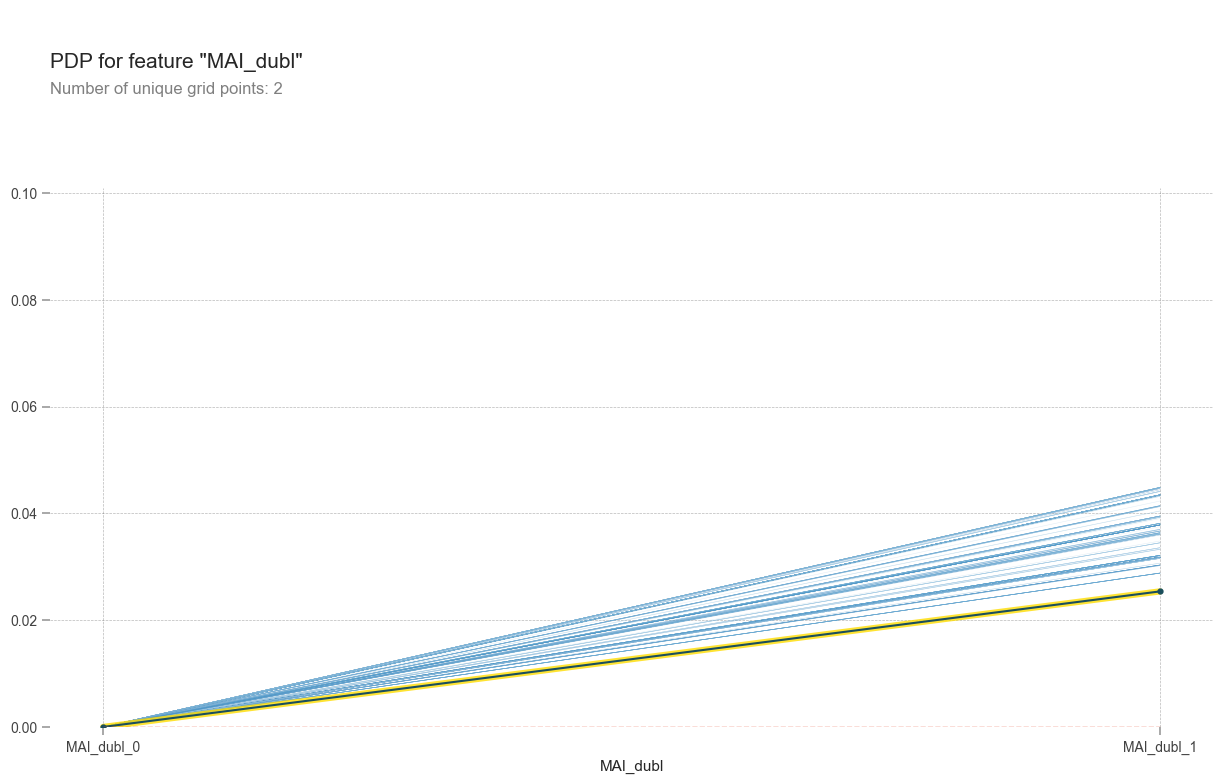

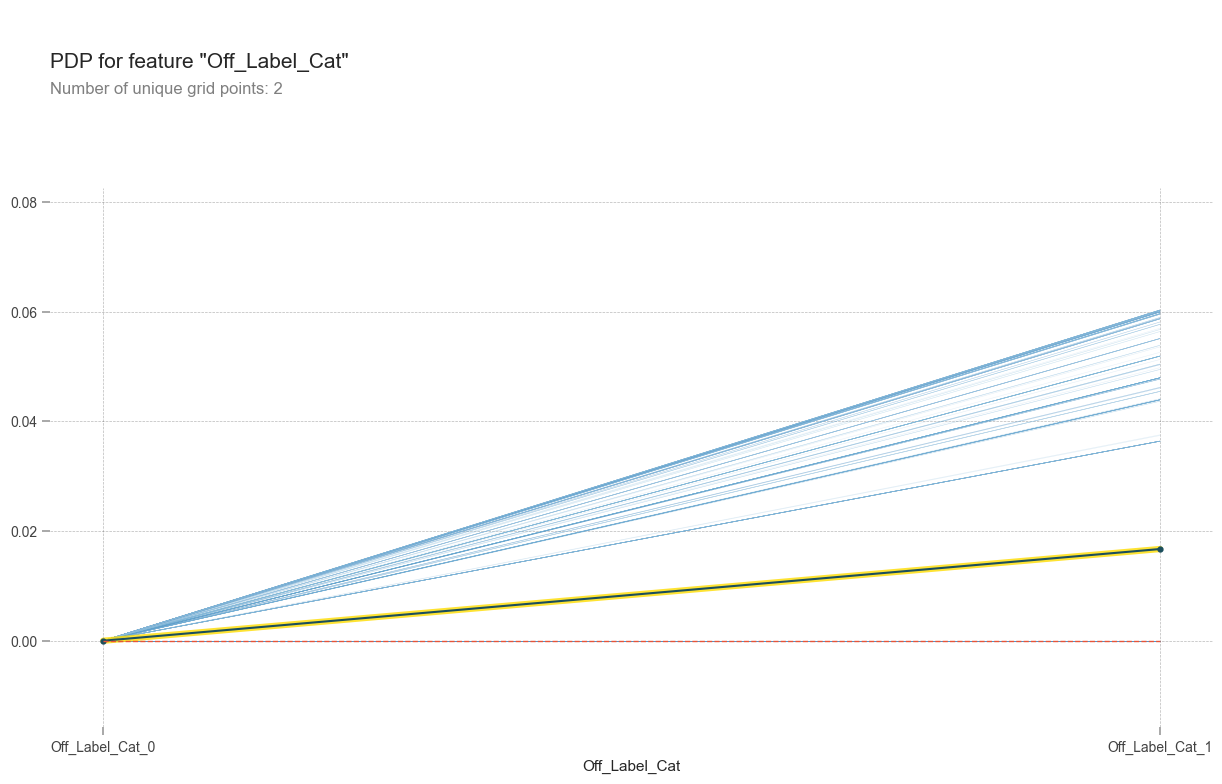

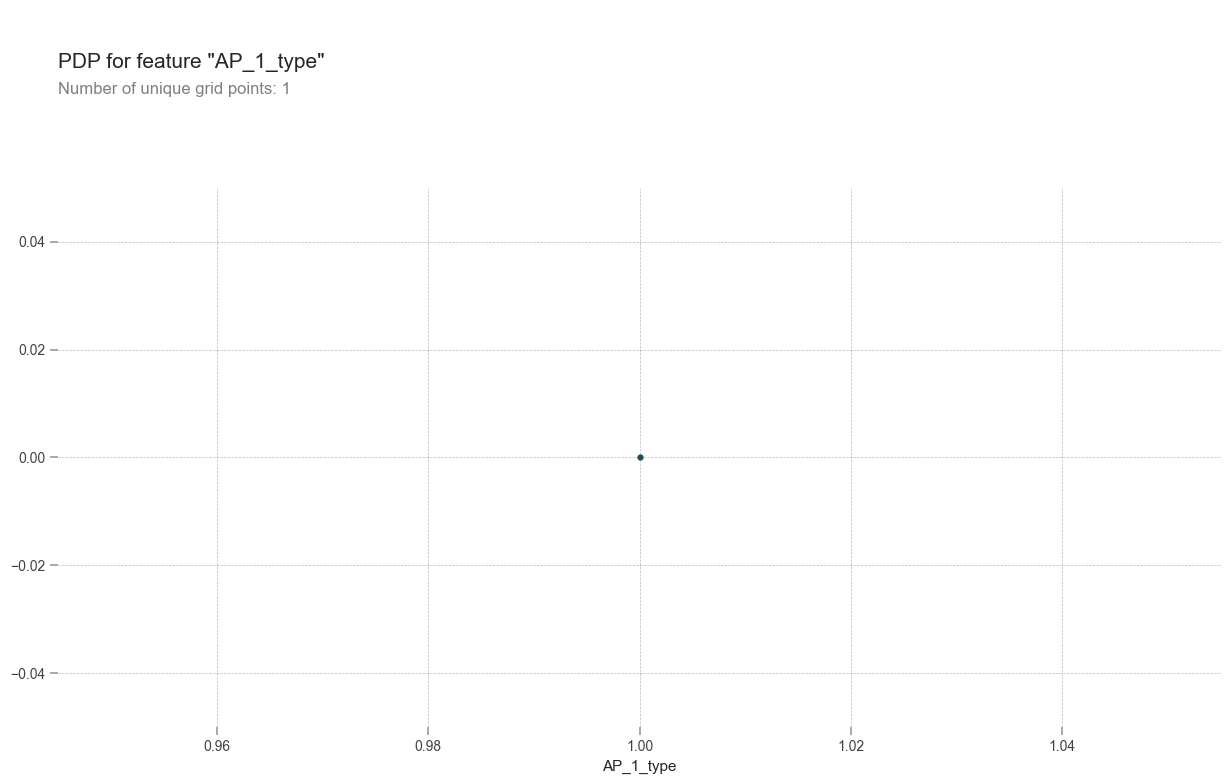

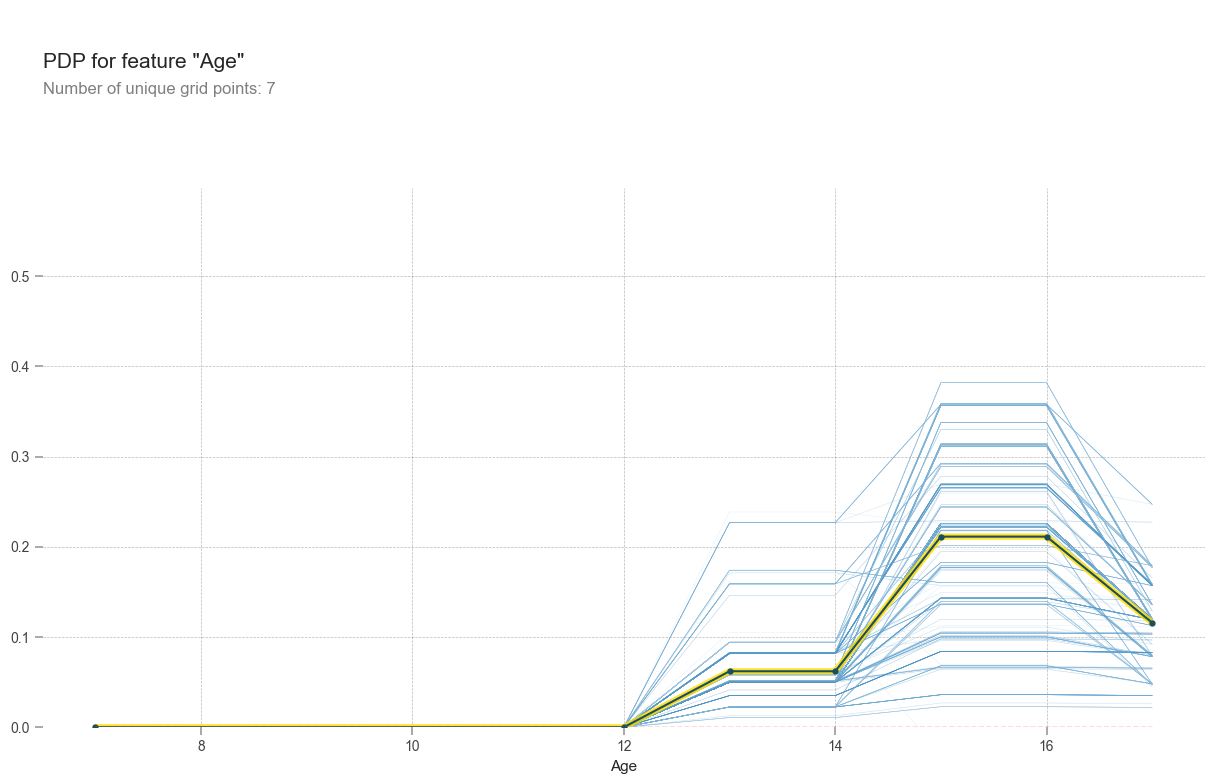

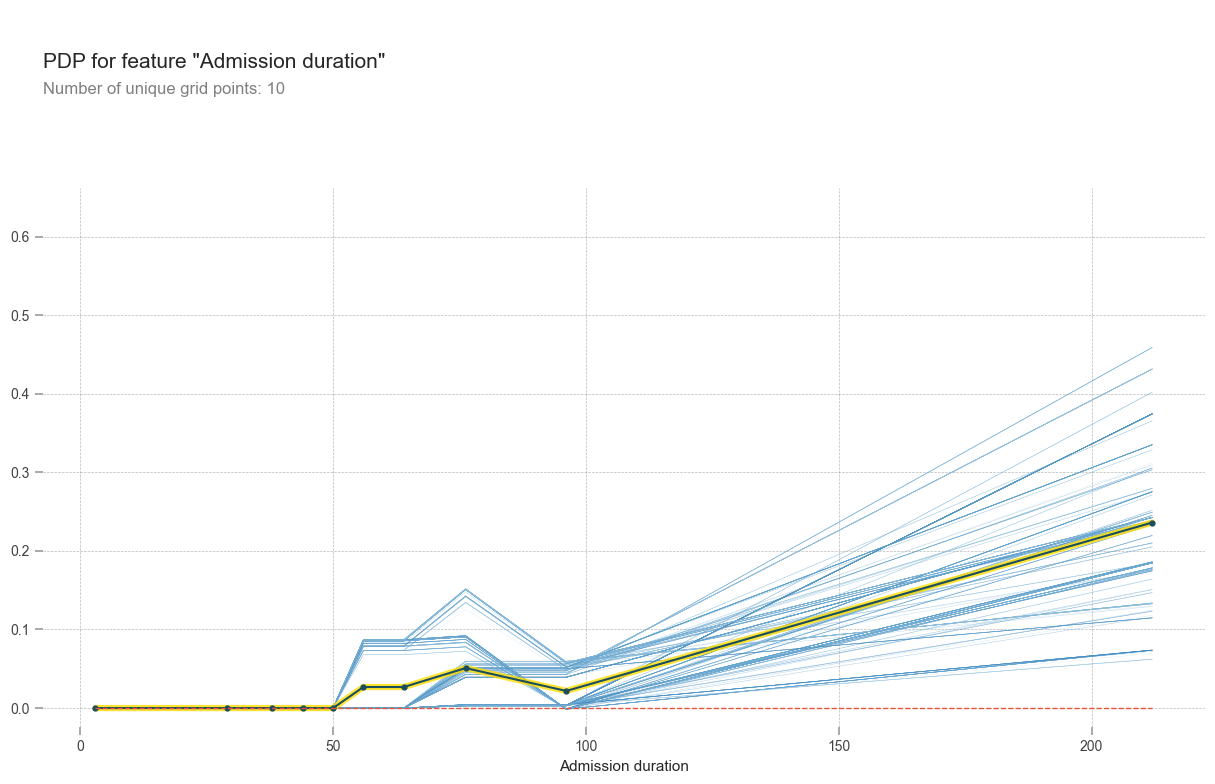

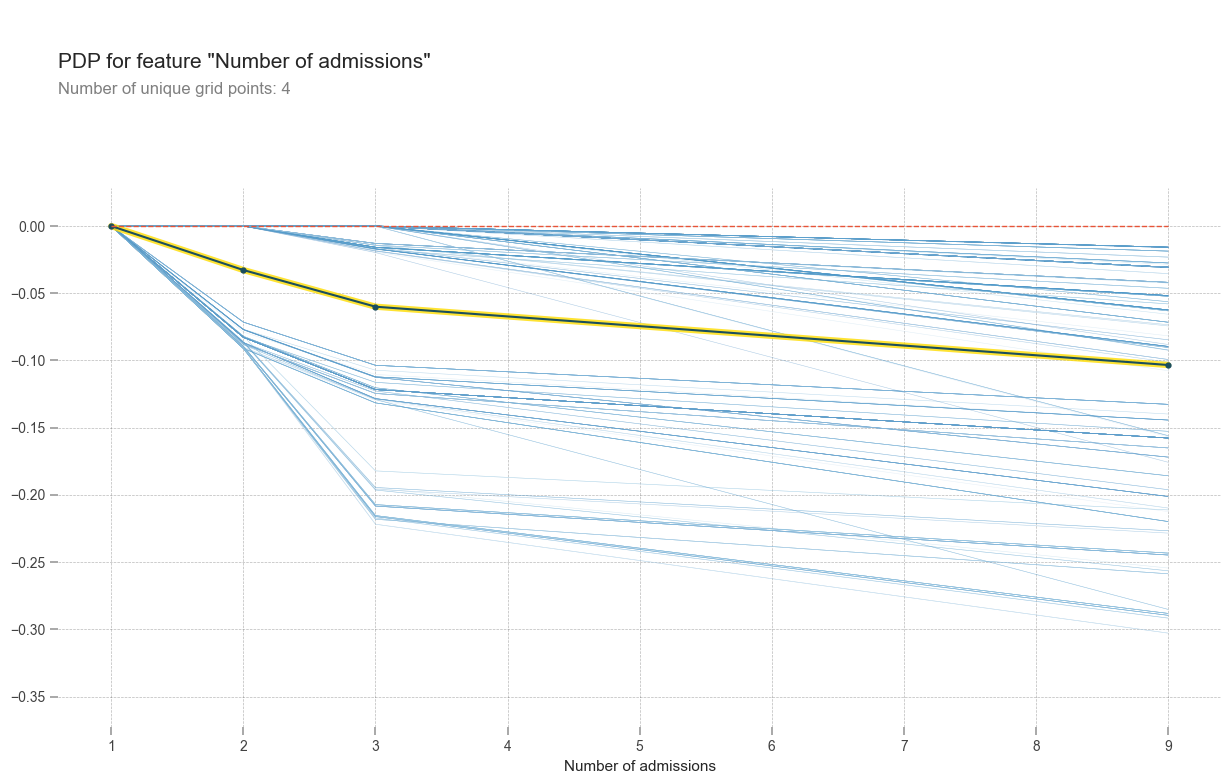

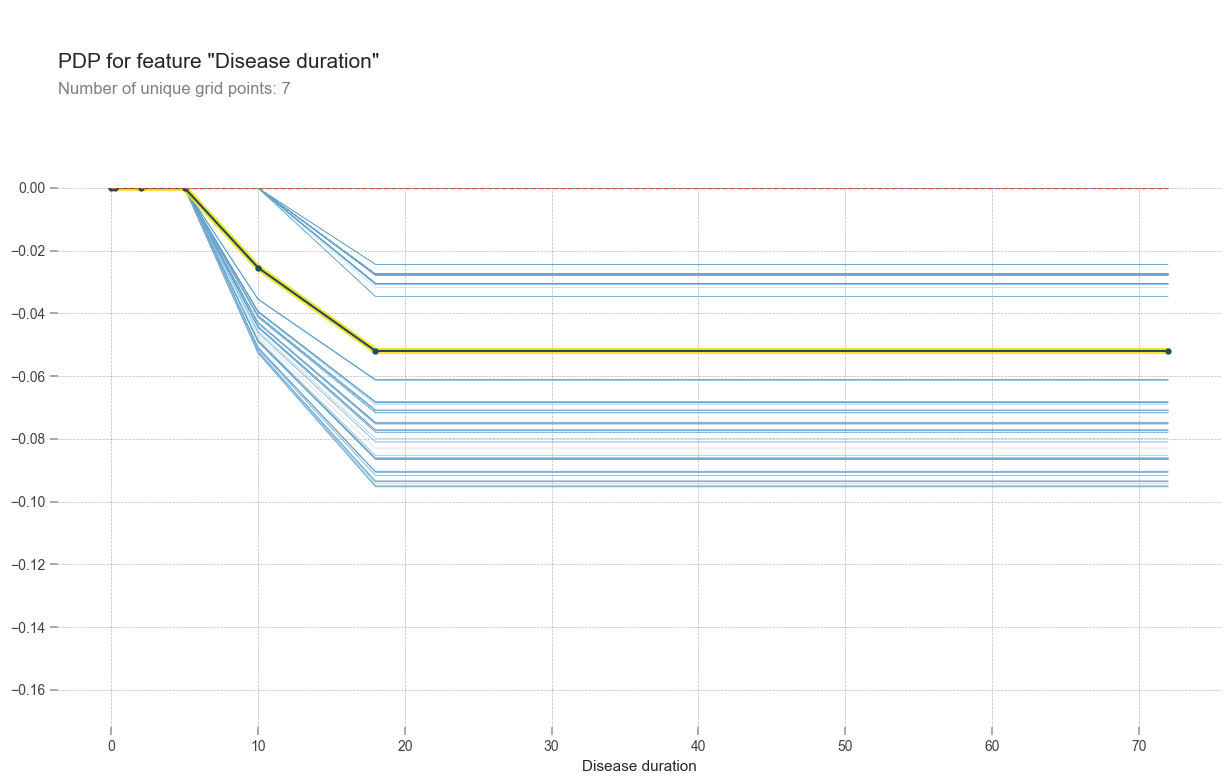

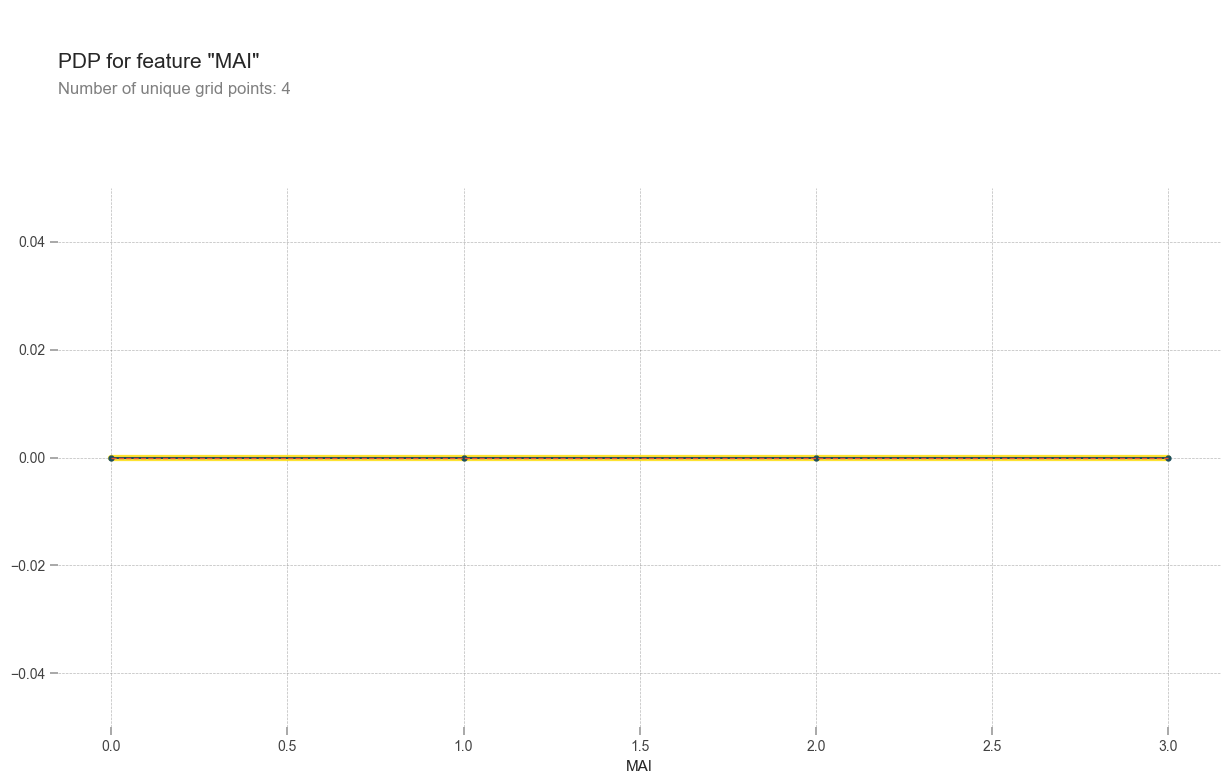

In [198]:
for col in X_local.columns:
    if col == 'Disease duration':
        plot_pdp(xg_classifier, X_local.dropna(), col)
    else:
        plot_pdp(xg_classifier, X_local, col)

# Models comparison table

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [199]:
def get_model_comparison_data(classifier, cv, X, y,):
    y_preds = []
    roc_aucs = []
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        y_preds.extend(classifier.predict(X[test]))
        roc_aucs.append(roc_auc_score(y[test], classifier.predict_proba(X[test])[:, 1]))
    
    precision, recall, fbeta_score, support = precision_recall_fscore_support(y, y_preds)
    return {
        'Mean ROC AUC': np.mean(roc_aucs),
        'Precision': precision,
        'Recall': recall,
        'F Beta Score': fbeta_score,
        'Support': support,
        
    }

In [200]:
models = [
    ('XGBoost', xgb.XGBClassifier(gamma=5)),
    ('KNeighbors Classifier', KNeighborsClassifier()),
    ('RandomForest Classifier 100 trees', RandomForestClassifier(max_depth=4, max_features=4)),
    ('RandomForest Classifier 200 trees', RandomForestClassifier(n_estimators=200, max_depth=4, max_features=4)),
    ('RandomForest Classifier 400 trees', RandomForestClassifier(n_estimators=400, max_depth=4, max_features=4)),
    ('SVM Classifier', SVC(probability=True)),
    ('LogisticRegression', LogisticRegression()),
]

cv = StratifiedKFold(n_splits=5)

res = {}
for name, model in models:
    res[name] = get_model_comparison_data(model, cv, X_local.fillna(0).to_numpy(), Y)

models_comparison_df = pd.DataFrame(res).T
models_comparison_df

[22:19:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

Mean ROC AUC  \
XGBoost                               0.663388   
KNeighbors Classifier                  0.59645   
RandomForest Classifier 100 trees     0.647248   
RandomForest Classifier 200 trees     0.651797   
RandomForest Classifier 400 trees      0.65143   
SVM Classifier                        0.508427   
LogisticRegression                    0.616481   

                                                                   Precision  \
XGBoost                             [0.7308584686774942, 0.5263157894736842]   
KNeighbors Classifier               [0.7466307277628033, 0.4050632911392405]   
RandomForest Classifier 100 trees   [0.7400468384074942, 0.6521739130434783]   
RandomForest Classifier 200 trees   [0.7429906542056075, 0.7272727272727273]   
RandomForest Classifier 400 trees   [0.7423887587822015, 0.6956521739130435]   
SVM Classifier                                     [0.7193763919821826, 0.0]   
LogisticRegression                 [0.7224770642201835, 0.35714285714285715]   

                                                                      Recall  \
XGBoost                            [0.9722222222222222, 0.07936507936507936]   
KNeighbors Classifier              [0.8549382716049383, 0.25396825396825395]   
RandomForest Classifier 100 trees  [0.9753086419753086, 0.11904761904761904]   
RandomForest Classifier 200 trees  [0.9814814814814815, 0.12698412698412698]   
RandomForest Classifier 400 trees  [0.9783950617283951, 0.12698412698412698]   
SVM Classifier                                     [0.9969135802469136, 0.0]   
LogisticRegression                 [0.9722222222222222, 0.03968253968253968]   

                                                                F Beta Score  \
XGBoost                            [0.8344370860927152, 0.13793103448275862]   
KNeighbors Classifier               [0.7971223021582734, 0.3121951219512195]   
RandomForest Classifier 100 trees  [0.8415446071904128, 0.20134228187919462]   
RandomForest Classifier 200 trees   [0.8457446808510638, 0.2162162162162162]   
RandomForest Classifier 400 trees    [0.844207723035952, 0.2147651006711409]   
SVM Classifier                                     [0.8357050452781372, 0.0]   
LogisticRegression                 [0.8289473684210527, 0.07142857142857141]   

                                      Support  
XGBoost                            [324, 126]  
KNeighbors Classifier              [324, 126]  
RandomForest Classifier 100 trees  [324, 126]  
RandomForest Classifier 200 trees  [324, 126]  
RandomForest Classifier 400 trees  [324, 126]  
SVM Classifier                     [324, 126]  
LogisticRegression                 [324, 126]

In [201]:
models_comparison_df.to_csv('models_copmarison.csv')